In [1]:
%tensorflow_version 1.x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse as RMSE

from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE


TensorFlow 1.x selected.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Set plotting style
sns.set()

# Format output numbers
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# %%
# Load datasets
# Historical data
panama = pd.read_csv('continuous dataset.csv',
                     parse_dates=['datetime'],
                     index_col='datetime')

# Official forecast data from CND
dispatch = pd.read_csv('weekly pre-dispatch forecast.csv',
                       parse_dates=['datetime'],
                       index_col='datetime')
panama.index
# %%
# Set the datetime frequency to hourly
panama = panama.asfreq('H')

In [3]:
index= panama.index.ceil("6D")
panama=panama[panama.index==index]

In [4]:
# View last 5 rows
panama.tail()
# %%


,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2020-06-01,999.658,25.556,0.019,0.099,6.110,24.087,0.018,0.075,4.331,22.681,0.017,0.153,3.783,0,0,0
2020-06-07,1184.385,26.962,0.020,0.052,7.379,25.743,0.019,0.095,3.932,23.087,0.018,0.047,2.387,0,0,0
2020-06-13,1049.865,25.978,0.019,0.061,7.387,24.056,0.018,0.086,4.545,22.993,0.018,0.297,4.441,0,0,1
2020-06-19,1074.466,26.838,0.020,0.011,12.543,25.448,0.020,0.147,4.362,23.463,0.018,0.202,3.623,0,0,1
2020-06-25,1102.619,27.068,0.021,0.030,10.212,25.162,0.019,0.050,1.804,23.224,0.018,0.102,2.784,0,0,1


In [5]:
X = panama.drop(columns='nat_demand')
y = panama.nat_demand

In [6]:
X.shape

(334, 15)

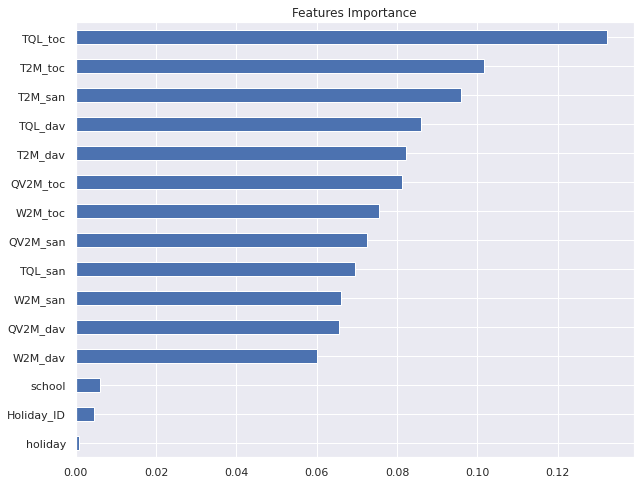

In [7]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)
importances = pd.Series(data=rf.feature_importances_,
                        index=X.columns).sort_values()

importances.plot(kind='barh', figsize=(10, 8))
plt.title('Features Importance')
plt.show()

In [8]:
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import LSTM
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Dropout

plt.rcParams['font.sans-serif']=['SimHei'] #
plt.rcParams['axes.unicode_minus']=False #

neurons = 512                 # number of hidden units in the LSTM layer
activation_function = 'relu'  # activation function for LSTM and Dense layer
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'adam'             # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each IndRNN layer to avoid overfitting
batch_size = 128
epochs = 5
window_len = 7               # is an intiger to be used as the look back window for creating a single input sample.
training_size = 0.8
from __future__ import absolute_import
import warnings
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import RNN

def _generate_dropout_mask(ones, rate, training=None, count=1):
    def dropped_inputs():
        return K.dropout(ones, rate)
    if count > 1:
        return [K.in_train_phase(
            dropped_inputs,
            ones,
            training=training) for _ in range(count)]
    return K.in_train_phase(
        dropped_inputs,
        ones,
        training=training)

class IndRNNCell(Layer):
    """Independently Recurrent Neural Networks Cell class.
    Derived from the paper [Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN](https://arxiv.org/abs/1803.04831)
    Ref: [Tensorflow implementation](https://github.com/batzner/indrnn)
    # Arguments
        units: Positive integer, dimensionality of the output space.
        recurrent_clip_min: Can be one of None, -1 or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, will calculate the clip value for `relu` activation
        recurrent_clip_max: Can be one of None or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, will calculate the clip value for `relu` activation
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you pass None, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix, used for the linear transformation of the
            recurrent state.
            Can be `None` or an available initializer. Defaults to `None`.
            If None, defaults to uniform initialization.
            If None, and recurrent_clip_min/max is not None, then
            it uses those clip values as for uniform initialization.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, must be 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
    """

    def __init__(self, units,
                 recurrent_clip_min=-2,
                 recurrent_clip_max=2,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer=None,
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 **kwargs):
        super(IndRNNCell, self).__init__(**kwargs)

        if implementation != 2:
            warnings.warn(
                "IndRNN only supports implementation 2 for the moment. Defaulting to implementation = 2")
            implementation = 2

        if recurrent_clip_min is None or recurrent_clip_max is None:
            recurrent_clip_min = None
            recurrent_clip_max = None

        self.units = units
        self.recurrent_clip_min = recurrent_clip_min
        self.recurrent_clip_max = recurrent_clip_max
        self.activation = activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer) \
                                     if recurrent_initializer is not None else None
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = (self.units,)
        self._dropout_mask = None
        self._recurrent_masks = None

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if self.recurrent_clip_min == -1 or self.recurrent_clip_max == -1:
            self.recurrent_clip_min = 0.0

            if hasattr(self, 'timesteps') and self.timesteps is not None:
                self.recurrent_clip_max = pow(2.0, 1. / int(self.timesteps))
            else:
                warnings.warn("IndRNNCell: Number of timesteps could not be determined. \n"
                              "Defaulting to max clipping range of 1.0. \n"
                              "If this model was trained using a specific timestep during training, "
                              "inference may be wrong due to this default setting.\n"
                              "Please ensure that you use the same number of timesteps during training "
                              "and evaluation")
                self.recurrent_clip_max = 1.0

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      name='input_kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.recurrent_initializer is None:
            if self.recurrent_clip_min is not None and self.recurrent_clip_max is not None:
                initialization_value = min(self.recurrent_clip_max, 1.0)
                self.recurrent_initializer = initializers.RandomUniform(-initialization_value,
                                                                  initialization_value)
            else:
                self.recurrent_initializer = initializers.RandomUniform(-1.0, 1.0)

        self.recurrent_kernel = self.add_weight(shape=(self.units,),
                                                name='recurrent_kernel',
                                                initializer=self.recurrent_initializer,
                                                regularizer=self.recurrent_regularizer,
                                                constraint=self.recurrent_constraint)

        if self.recurrent_clip_min is not None and self.recurrent_clip_max is not None:
            if abs(self.recurrent_clip_min):
                abs_recurrent_kernel = K.abs(self.recurrent_kernel)
                min_recurrent_kernel = K.maximum(abs_recurrent_kernel, abs(self.recurrent_clip_min))
                self.recurrent_kernel = K.sign(self.recurrent_kernel) * min_recurrent_kernel

            self.recurrent_kernel = K.clip(self.recurrent_kernel,
                                           self.recurrent_clip_min,
                                           self.recurrent_clip_max)

        if self.use_bias:
            bias_initializer = self.bias_initializer

            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.built = True

    def call(self, inputs, states, training=None):
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=1)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_masks is None):
            _recurrent_mask = _generate_dropout_mask(
                K.ones_like(states[0]),
                self.recurrent_dropout,
                training=training,
                count=1)
            self._recurrent_masks = _recurrent_mask

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_masks = self._recurrent_masks

        h_tm1 = states[0]  # previous state

        if 0. < self.dropout < 1.:
            inputs *= dp_mask[0]

        if 0. < self.recurrent_dropout < 1.:
            h_tm1 *= rec_dp_masks[0]

        h = K.dot(inputs, self.kernel)
        h = h + (h_tm1 * self.recurrent_kernel)

        if self.use_bias:
            h = K.bias_add(h, self.bias)

        h = self.activation(h)

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True
        return h, [h]

    def get_config(self):
        config = {'units': self.units,
                  'recurrent_clip_min': self.recurrent_clip_min,
                  'recurrent_clip_max': self.recurrent_clip_max,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(IndRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class IndRNN(RNN):
    """Independently Recurrent Neural Networks Cell class.
    Derived from the paper [Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN](https://arxiv.org/abs/1803.04831)
    Ref: [Tensorflow implementation](https://github.com/batzner/indrnn)
    # Arguments
        units: Positive integer, dimensionality of the output space.
        recurrent_clip_min: Can be one of None, -1 or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, computes the default clipping range for Relu activations
        recurrent_clip_max: Can be one of None, -1 or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, computes the default clipping range for Relu activations
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you pass None, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs.
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        unit_forget_bias: Boolean.
            If True, add 1 to the bias of the forget gate at initialization.
            Setting it to true will also force `bias_initializer="zeros"`.
            This is recommended in [Jozefowicz et al.](http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf)
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output.
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
    # References
        - [Learning to forget: Continual prediction with NestedLSTM](http://www.mitpressjournals.org/doi/pdf/10.1162/089976600300015015)
        - [Supervised sequence labeling with recurrent neural networks](http://www.cs.toronto.edu/~graves/preprint.pdf)
        - [A Theoretically Grounded Application of Dropout in Recurrent Neural Networks](http://arxiv.org/abs/1512.05287)
        - [Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN](https://arxiv.org/abs/1803.04831)
    """

    def __init__(self, units,
                 recurrent_clip_min=-1,
                 recurrent_clip_max=-1,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer=None,
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=2`.'
                          'Please update your layer call.')
        if K.backend() == 'theano':
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = IndRNNCell(units,
                          recurrent_clip_min=recurrent_clip_min,
                          recurrent_clip_max=recurrent_clip_max,
                          activation=activation,
                          use_bias=use_bias,
                          kernel_initializer=kernel_initializer,
                          recurrent_initializer=recurrent_initializer,
                          bias_initializer=bias_initializer,
                          kernel_regularizer=kernel_regularizer,
                          recurrent_regularizer=recurrent_regularizer,
                          bias_regularizer=bias_regularizer,
                          kernel_constraint=kernel_constraint,
                          recurrent_constraint=recurrent_constraint,
                          bias_constraint=bias_constraint,
                          dropout=dropout,
                          recurrent_dropout=recurrent_dropout,
                          implementation=implementation)
        super(IndRNN, self).__init__(cell,
                                     return_sequences=return_sequences,
                                     return_state=return_state,
                                     go_backwards=go_backwards,
                                     stateful=stateful,
                                     unroll=unroll,
                                     **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def build(self, input_shape):
        timesteps = input_shape[1]

        if timesteps is None:
            warnings.warn("Number of timesteps was not provided. If this model is being used for training purposes, \n"
                          "it is recommended to provide a finite number of timesteps when defining the input shape, \n"
                          "so as to initialize the weights of the recurrent kernel properly and avoid exploding gradients.")

        self.cell.timesteps = timesteps

        super(IndRNN, self).build(input_shape)

    def call(self, inputs, mask=None, training=None, initial_state=None, constants=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_masks = None
        return super(IndRNN, self).call(inputs,
                                        mask=mask,
                                        training=training,
                                        initial_state=initial_state,
                                        constants=constants)

    @property
    def units(self):
        return self.cell.units

    @property
    def recurrent_clip_min(self):
        return self.cell.recurrent_clip_min

    @property
    def recurrent_clip_max(self):
        return self.cell.recurrent_clip_max

    @property
    def activation(self):
        return self.cell.activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'recurrent_clip_min': self.recurrent_clip_min,
                  'recurrent_clip_max': self.recurrent_clip_max,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(IndRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 2
        return cls(**config)
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  #from __future__ import absolute_import
  import warnings

  from tensorflow.keras import backend as K
  from tensorflow.keras import activations
  from tensorflow.keras import initializers
  from tensorflow.keras import regularizers
  from tensorflow.keras import constraints
  from tensorflow.keras.layers import Layer
  from tensorflow.keras.layers import InputSpec
  from tensorflow.keras.layers import RNN

      
  model = Sequential()
  model.add(IndRNN(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(IndRNN(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(IndRNN(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.MeanAbsolutePercentageError(),tf.keras.metrics.MeanAbsoluteError()])
  model.summary()
  return model



In [9]:
#X, y
X = X.astype('float32')

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X)

In [11]:
ind=int(X.shape[0]*0.8)
train_x, test_x, train_y, test_y = X[0:ind].values,X[ind:].values,y[0:ind],y[ind:]#train_test_split(X.values, y, random_state=1, train_size=0.8)
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(267, 1, 15) (267,) (67, 1, 15) (67,)


*_____________________________________________________________________________*
	batchsize: 16 	block: 4
*_____________________________________________________________________________*
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ind_rnn (IndRNN)             (None, 1, 4)              64        
_________________________________________________________________
dropout (Dropout)            (None, 1, 4)              0         
_________________________________________________________________
ind_rnn_1 (IndRNN)           (None, 1, 4)              20        
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 4)              0         
__

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


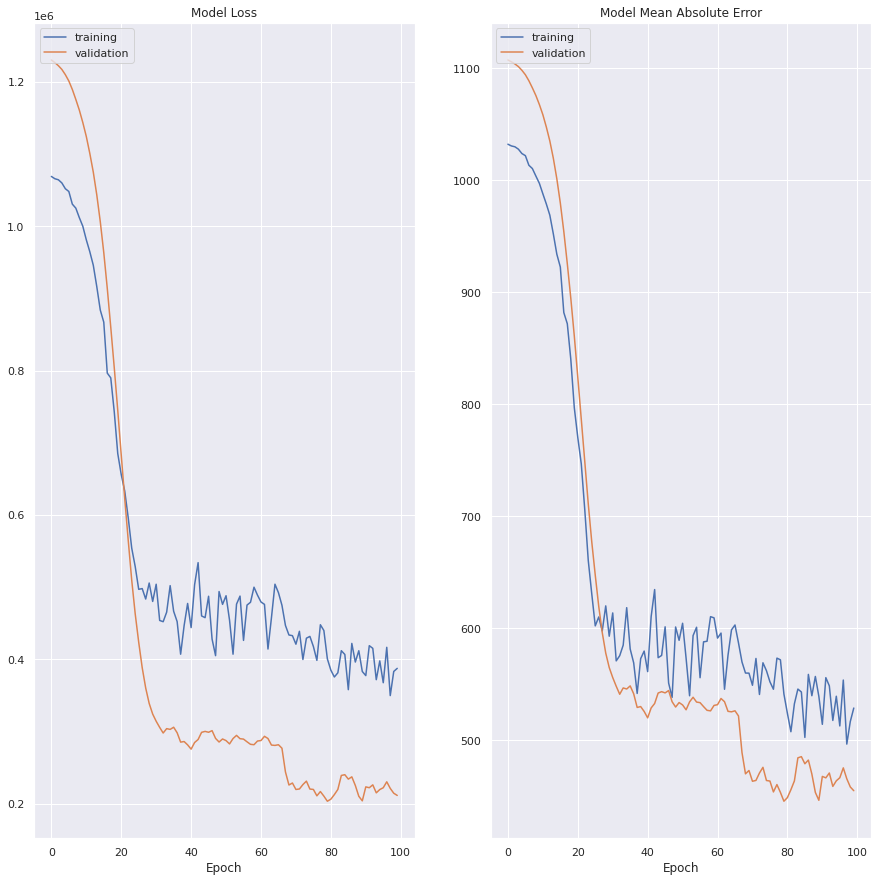

*_____________________________________________________________________________*
	batchsize: 16 	block: 7
*_____________________________________________________________________________*
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ind_rnn_3 (IndRNN)           (None, 1, 7)              112       
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 7)              0         
_________________________________________________________________
ind_rnn_4 (IndRNN)           (None, 1, 7)              56        
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 7)              0         
_________________________________________________________________
ind_rnn_5 (IndRNN)           (None, 7)                 56        
_________________________________________________________________
d

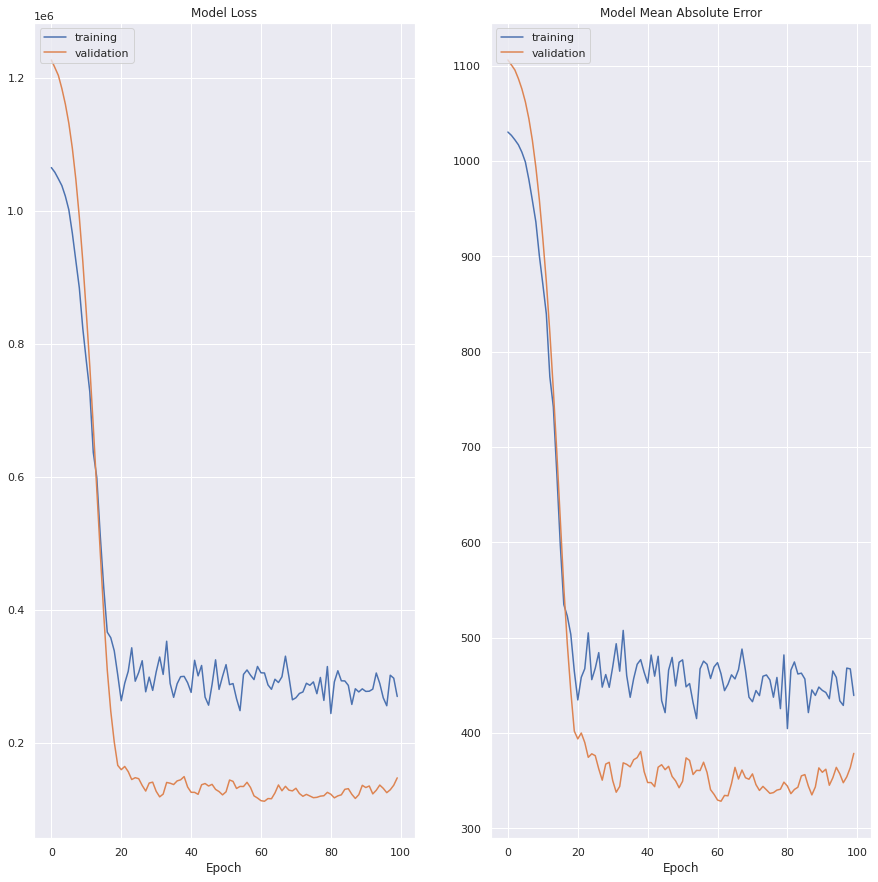

*_____________________________________________________________________________*
	batchsize: 16 	block: 10
*_____________________________________________________________________________*
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ind_rnn_6 (IndRNN)           (None, 1, 10)             160       
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
ind_rnn_7 (IndRNN)           (None, 1, 10)             110       
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
ind_rnn_8 (IndRNN)           (None, 10)                110       
_________________________________________________________________


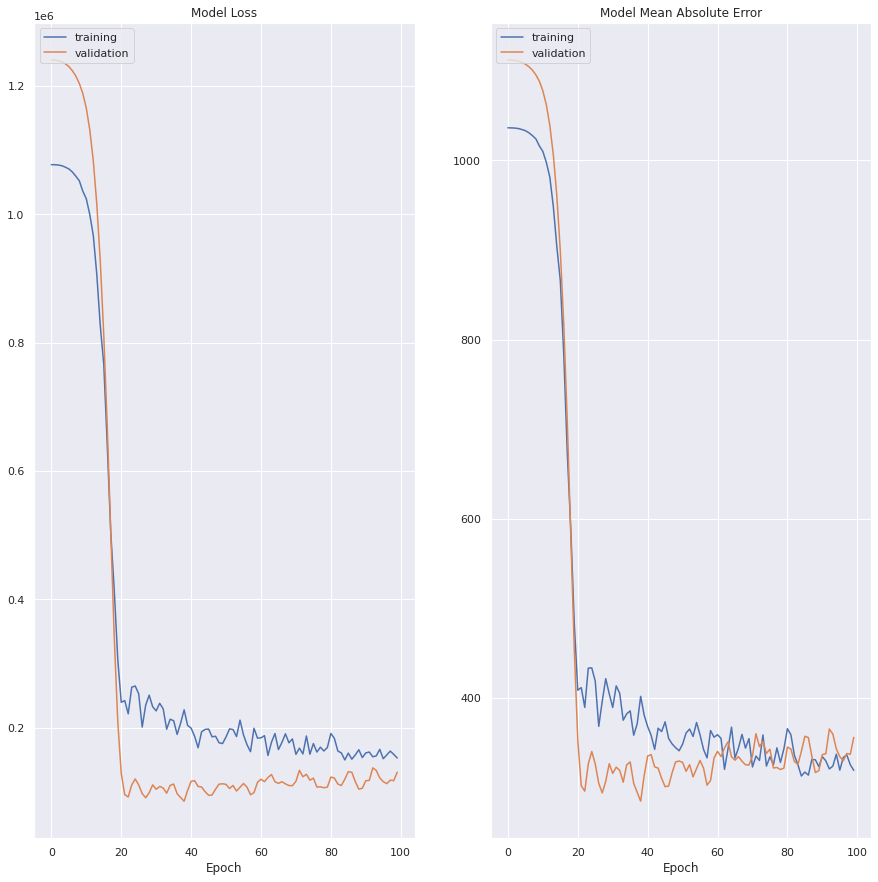

*_____________________________________________________________________________*
	batchsize: 16 	block: 15
*_____________________________________________________________________________*
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ind_rnn_9 (IndRNN)           (None, 1, 15)             240       
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 15)             0         
_________________________________________________________________
ind_rnn_10 (IndRNN)          (None, 1, 15)             240       
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 15)             0         
_________________________________________________________________
ind_rnn_11 (IndRNN)          (None, 15)                240       
_________________________________________________________________


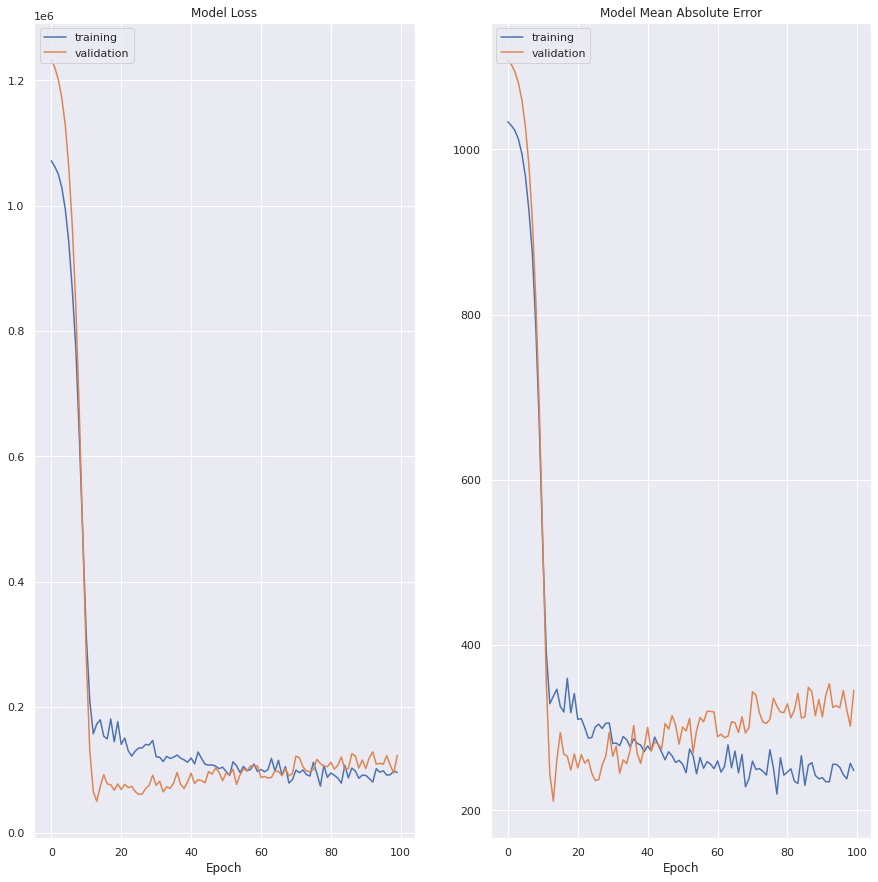

*_____________________________________________________________________________*
	batchsize: 32 	block: 4
*_____________________________________________________________________________*
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ind_rnn_12 (IndRNN)          (None, 1, 4)              64        
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 4)              0         
_________________________________________________________________
ind_rnn_13 (IndRNN)          (None, 1, 4)              20        
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 4)              0         
_________________________________________________________________
ind_rnn_14 (IndRNN)          (None, 4)                 20        
_________________________________________________________________
d

KeyboardInterrupt: ignored

In [12]:

# design network

for batchsize in[16,32,64,128,256]:
  for block in [4,7,10,15]:
    print("*_____________________________________________________________________________*")
    print('\tbatchsize:', batchsize,'\tblock:', block)
    print("*_____________________________________________________________________________*")
    model = build_model(train_x, output_size=1, neurons=block)
    history = model.fit(train_x, train_y, epochs=100, batch_size=batchsize,
                        verbose=1, validation_data=(test_x, test_y), shuffle=False)
    fig = plt.figure(figsize=(15,15))
    subfig = fig.add_subplot(122)
    subfig.plot(history.history['mean_absolute_error'], label="training")
    if history.history['val_mean_absolute_error'] is not None:
        subfig.plot(history.history['val_mean_absolute_error'], label="validation")
    subfig.set_title('Model Mean Absolute Error')
    subfig.set_xlabel('Epoch')
    subfig.legend(loc='upper left')
    subfig = fig.add_subplot(121)
    subfig.plot(history.history['loss'], label="training")
    if history.history['val_loss'] is not None:
        subfig.plot(history.history['val_loss'], label="validation")
    subfig.set_title('Model Loss')
    subfig.set_xlabel('Epoch')
    subfig.legend(loc='upper left')
    plt.show()
    plt.close()

In [13]:
!pip install optuna

     |████████████████████████████████| 308 kB 18.7 MB/s 
     |████████████████████████████████| 80 kB 7.4 MB/s 
     |████████████████████████████████| 209 kB 40.6 MB/s 
     |████████████████████████████████| 75 kB 3.4 MB/s 
     |████████████████████████████████| 149 kB 41.0 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 112 kB 41.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=7497af4d4787ea93e64eb608d1b48ae76650584e7df189f88bd400cac2ec6115
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [14]:
import optuna
study_name = 'xgbr_'  # Unique identifier of the study.
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            study_name=study_name, 
                            storage='sqlite:///xgbr_.db')
# model creation
import tensorflow as tf
from tensorflow import keras 

def create_lstm_model(trial):
    train=train_x

    x0 = tf.keras.layers.Input(shape=(train.shape[-2], train.shape[-1]))  

    lstm_layers = 4
    lstm_units = np.zeros(lstm_layers, dtype=np.int)
    lstm_units[0] = trial.suggest_int("lstm_units_L1", 768, 1536)
    lstm = IndRNN(lstm_units[0], return_sequences=True)(x0)
    for i in range(lstm_layers-1):
        lstm_units[i+1] = trial.suggest_int("lstm_units_L{}".format(i+2), lstm_units[i]//2, lstm_units[i])
        lstm = IndRNN(lstm_units[i+1], return_sequences=True)(lstm)    
    dropout_rate = trial.suggest_float("lstm_dropout", 0.0, 0.3)
    lstm = Dropout(dropout_rate)(lstm)
    dense_units = lstm_units[-1]
    # try different activations
    activation = trial.suggest_categorical("activation", ["relu", "selu", "elu"])
    lstm = Dense(dense_units, activation=activation)(lstm)
    lstm = Dense(1)(lstm)

    model = keras.Model(inputs=x0, outputs=lstm)
    metrics = ["mae"]
    model.compile(optimizer="adam", loss="mae", metrics=metrics)
    
    return model

[I 2021-12-31 09:02:04,227] A new study created in RDB with name: xgbr_


In [17]:
'''train_x, train_y, epochs=100, batch_size=batchsize,
                        verbose=1, validation_data=(test_x, test_y)'''
EPOCHS = 30 # number of epocs per trial
from typing import Any
from typing import Dict
from typing import Optional
import warnings

import optuna


with optuna._imports.try_import() as _imports:
    from tensorflow.keras.callbacks import Callback

if not _imports.is_successful():
    Callback = object  # NOQA


class TFKerasPruningCallback(Callback):
    """tf.keras callback to prune unpromising trials.

    This callback is intend to be compatible for TensorFlow v1 and v2,
    but only tested with TensorFlow v2.

    See `the example <https://github.com/optuna/optuna-examples/blob/main/
    tfkeras/tfkeras_integration.py>`__
    if you want to add a pruning callback which observes the validation accuracy.

    Args:
        trial:
            A :class:`~optuna.trial.Trial` corresponding to the current evaluation of the
            objective function.
        monitor:
            An evaluation metric for pruning, e.g., ``val_loss`` or ``val_acc``.
    """

    def __init__(self, trial: optuna.trial.Trial, monitor: str) -> None:

        super().__init__()

        _imports.check()

        self._trial = trial
        self._monitor = monitor

    def on_epoch_end(self, epoch: int, logs: Optional[Dict[str, Any]] = None) -> None:

        logs = logs or {}
        current_score = logs.get(self._monitor)

        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self._monitor)
            )
            warnings.warn(message)
            return

        # Report current score and epoch to Optuna's trial.
        self._trial.report(float(current_score), step=epoch)

        # Prune trial if needed
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            raise optuna.TrialPruned(message)
import enum


class TrialState(enum.Enum):
    """State of a :class:`~optuna.trial.Trial`.

    Attributes:
        RUNNING:
            The :class:`~optuna.trial.Trial` is running.
        WAITING:
            The :class:`~optuna.trial.Trial` is waiting and unfinished.
        COMPLETE:
            The :class:`~optuna.trial.Trial` has been finished without any error.
        PRUNED:
            The :class:`~optuna.trial.Trial` has been pruned with
            :class:`~optuna.exceptions.TrialPruned`.
        FAIL:
            The :class:`~optuna.trial.Trial` has failed due to an uncaught error.
    """

    RUNNING = 0
    COMPLETE = 1
    PRUNED = 2
    FAIL = 3
    WAITING = 4

    def __repr__(self) -> str:

        return str(self)

    def is_finished(self) -> bool:

        return self != TrialState.RUNNING and self != TrialState.WAITING
def objective(trial):
    train=train_x
    
    # Clear clutter from previous session graphs.
    keras.backend.clear_session()
    
    BATCH_SIZE=512
        # Generate our trial model.
    model = create_lstm_model(trial)

        # learning rate scheduler
    scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 400*((len(train)*0.8)/BATCH_SIZE), 1e-5)
    lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
    model.fit(train_x, train_y,
            batch_size=512,
            callbacks=[TFKerasPruningCallback(trial, "val_loss")],
            epochs=10,
            validation_data=(test_x, test_y),
            verbose=1,)

        # Evaluate the model accuracy on the validation set.
    score = model.evaluate(test_x, test_y, verbose=0)
    return score[1]

In [18]:
import optuna
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=100)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

[I 2021-12-31 09:04:18,593] A new study created in memory with name: no-name-2a1ad611-0935-48b7-8e6c-9cc220aed370


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 5ms/sample - loss: 1036.9939 - mean_absolute_error: 1036.9939 - val_loss: 1108.4779 - val_mean_absolute_error: 1108.4779
Epoch 2/10
267/267 [==============================] - 0s 366us/sample - loss: 1032.9347 - mean_absolute_error: 1032.9347 - val_loss: 1102.6399 - val_mean_absolute_error: 1102.6399
Epoch 3/10
267/267 [==============================] - 0s 419us/sample - loss: 1027.2665 - mean_absolute_error: 1027.2665 - val_loss: 1093.9706 - val_mean_absolute_error: 1093.9706
Epoch 4/10
267/267 [==============================] - 0s 239us/sample - loss: 1018.6591 - mean_absolute_error: 1018.6591 - val_loss: 1081.0537 - val_mean_absolute_error: 1081.0537
Epoch 5/10
267/267 [==============================] - 0s 271us/sample - loss: 1005.5352 - mean_absolute_error: 1005.5352 - val_loss: 1061.9629 - val_mean_absolute_error: 1061.9629
Epoch 6/10
267/267 [==============================] - 0s 

[I 2021-12-31 09:04:24,177] Trial 0 finished with value: 755.3604736328125 and parameters: {'lstm_units_L1': 971, 'lstm_units_L2': 576, 'lstm_units_L3': 307, 'lstm_units_L4': 217, 'lstm_dropout': 0.11472414570476719, 'activation': 'relu'}. Best is trial 0 with value: 755.3604736328125.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 2s 6ms/sample - loss: 1035.8694 - mean_absolute_error: 1035.8694 - val_loss: 1099.5273 - val_mean_absolute_error: 1099.5273
Epoch 2/10
267/267 [==============================] - 0s 489us/sample - loss: 1023.8851 - mean_absolute_error: 1023.8851 - val_loss: 1077.8276 - val_mean_absolute_error: 1077.8276
Epoch 3/10
267/267 [==============================] - 0s 538us/sample - loss: 1002.1816 - mean_absolute_error: 1002.1816 - val_loss: 1039.2673 - val_mean_absolute_error: 1039.2673
Epoch 4/10
267/267 [==============================] - 0s 555us/sample - loss: 963.2669 - mean_absolute_error: 963.2669 - val_loss: 973.0052 - val_mean_absolute_error: 973.0052
Epoch 5/10
267/267 [==============================] - 0s 567us/sample - loss: 896.3026 - mean_absolute_error: 896.3026 - val_loss: 864.8009 - val_mean_absolute_error: 864.8009
Epoch 6/10
267/267 [==============================] - 0s 559us/sa

[I 2021-12-31 09:04:30,533] Trial 1 finished with value: 296.5956726074219 and parameters: {'lstm_units_L1': 1219, 'lstm_units_L2': 910, 'lstm_units_L3': 477, 'lstm_units_L4': 358, 'lstm_dropout': 0.05313452677953273, 'activation': 'relu'}. Best is trial 1 with value: 296.5956726074219.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 5ms/sample - loss: 1036.3353 - mean_absolute_error: 1036.3353 - val_loss: 1104.9026 - val_mean_absolute_error: 1104.9026
Epoch 2/10
267/267 [==============================] - 0s 225us/sample - loss: 1029.1163 - mean_absolute_error: 1029.1163 - val_loss: 1094.2047 - val_mean_absolute_error: 1094.2047
Epoch 3/10
267/267 [==============================] - 0s 217us/sample - loss: 1018.9692 - mean_absolute_error: 1018.9692 - val_loss: 1077.2488 - val_mean_absolute_error: 1077.2488
Epoch 4/10
267/267 [==============================] - 0s 219us/sample - loss: 1001.7079 - mean_absolute_error: 1001.7079 - val_loss: 1050.8530 - val_mean_absolute_error: 1050.8530
Epoch 5/10
267/267 [==============================] - 0s 257us/sample - loss: 974.7961 - mean_absolute_error: 974.7961 - val_loss: 1010.2736 - val_mean_absolute_error: 1010.2736
Epoch 6/10
267/267 [==============================] - 0s 22

[I 2021-12-31 09:04:35,233] Trial 2 finished with value: 317.53900146484375 and parameters: {'lstm_units_L1': 962, 'lstm_units_L2': 680, 'lstm_units_L3': 372, 'lstm_units_L4': 210, 'lstm_dropout': 0.27970929504011405, 'activation': 'relu'}. Best is trial 1 with value: 296.5956726074219.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.7012 - mean_absolute_error: 1036.7012 - val_loss: 1092.7013 - val_mean_absolute_error: 1092.7013
Epoch 2/10
267/267 [==============================] - 0s 507us/sample - loss: 1017.0740 - mean_absolute_error: 1017.0740 - val_loss: 1059.7943 - val_mean_absolute_error: 1059.7943
Epoch 3/10
267/267 [==============================] - 0s 509us/sample - loss: 984.1085 - mean_absolute_error: 984.1085 - val_loss: 997.1943 - val_mean_absolute_error: 997.1943
Epoch 4/10
267/267 [==============================] - 0s 520us/sample - loss: 921.0885 - mean_absolute_error: 921.0885 - val_loss: 880.7473 - val_mean_absolute_error: 880.7473
Epoch 5/10
267/267 [==============================] - 0s 505us/sample - loss: 803.8478 - mean_absolute_error: 803.8478 - val_loss: 677.1525 - val_mean_

[I 2021-12-31 09:04:39,239] Trial 3 finished with value: 205.1735382080078 and parameters: {'lstm_units_L1': 1459, 'lstm_units_L2': 976, 'lstm_units_L3': 651, 'lstm_units_L4': 529, 'lstm_dropout': 0.05204861218375917, 'activation': 'selu'}. Best is trial 3 with value: 205.1735382080078.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1035.0726 - mean_absolute_error: 1035.0726 - val_loss: 1091.7737 - val_mean_absolute_error: 1091.7737
Epoch 2/10
267/267 [==============================] - 0s 408us/sample - loss: 1016.2961 - mean_absolute_error: 1016.2961 - val_loss: 1058.0377 - val_mean_absolute_error: 1058.0377
Epoch 3/10
267/267 [==============================] - 0s 431us/sample - loss: 982.5841 - mean_absolute_error: 982.5841 - val_loss: 994.6428 - val_mean_absolute_error: 994.6428
Epoch 4/10
267/267 [==============================] - 0s 425us/sample - loss: 918.4879 - mean_absolute_error: 918.4879 - val_loss: 879.3564 - val_mean_absolute_error: 879.3564
Epoch 5/10
267/267 [==============================] - 0s 428us/sample - loss: 803.1547 - mean_absolute_error: 803.1547 - val_loss: 679.5150 - val_mean_absolute_error: 679.5150
Epoch 6/10
267/267 [==============================] - 0s 432us/sample

[I 2021-12-31 09:04:42,838] Trial 4 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1036.8235 - mean_absolute_error: 1036.8235 - val_loss: 1102.9521 - val_mean_absolute_error: 1102.9521
Epoch 2/10
267/267 [==============================] - 0s 258us/sample - loss: 1027.3074 - mean_absolute_error: 1027.3074 - val_loss: 1093.7080 - val_mean_absolute_error: 1093.7080
Epoch 3/10
267/267 [==============================] - 0s 277us/sample - loss: 1018.0745 - mean_absolute_error: 1018.0745 - val_loss: 1080.9225 - val_mean_absolute_error: 1080.9225
Epoch 4/10


[I 2021-12-31 09:04:45,513] Trial 5 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1036.5771 - mean_absolute_error: 1036.5771 - val_loss: 1098.8322 - val_mean_absolute_error: 1098.8322


[I 2021-12-31 09:04:48,138] Trial 6 pruned. Trial was pruned at epoch 1.


Epoch 2/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1034.0913 - mean_absolute_error: 1034.0913 - val_loss: 1084.3588 - val_mean_absolute_error: 1084.3588
Epoch 2/10
267/267 [==============================] - 0s 487us/sample - loss: 1009.1298 - mean_absolute_error: 1009.1298 - val_loss: 1041.6259 - val_mean_absolute_error: 1041.6259
Epoch 3/10
267/267 [==============================] - 0s 557us/sample - loss: 966.0578 - mean_absolute_error: 966.0578 - val_loss: 962.2309 - val_mean_absolute_error: 962.2309
Epoch 4/10
267/267 [==============================] - 0s 488us/sample - loss: 886.2437 - mean_absolute_error: 886.2437 - val_loss: 819.6492 - val_mean_absolute_error: 819.6492
Epoch 5/10
267/267 [==============================] - 0s 496us/sample - loss: 742.0189 - mean_absolute_error: 742.0189 - val_loss: 578.2837 - val_mean_absolute_error: 578.2837
Epoch 6/10
267/267 [==============================] - 0s 4

[I 2021-12-31 09:04:52,650] Trial 7 finished with value: 104.74243927001953 and parameters: {'lstm_units_L1': 1459, 'lstm_units_L2': 1086, 'lstm_units_L3': 566, 'lstm_units_L4': 458, 'lstm_dropout': 0.16743137431904936, 'activation': 'selu'}. Best is trial 7 with value: 104.74243927001953.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1036.8347 - mean_absolute_error: 1036.8347 - val_loss: 1106.0497 - val_mean_absolute_error: 1106.0497
Epoch 2/10
267/267 [==============================] - 0s 298us/sample - loss: 1030.5408 - mean_absolute_error: 1030.5408 - val_loss: 1095.5863 - val_mean_absolute_error: 1095.5863
Epoch 3/10
267/267 [==============================] - 0s 266us/sample - loss: 1020.1213 - mean_absolute_error: 1020.1213 - val_loss: 1076.2175 - val_mean_absolute_error: 1076.2175
Epoch 4/10
267/267 [==============================] - 0s 269us/sample - loss: 1001.1169 - mean_absolute_error: 1001.1169 - val_loss: 1043.3302 - val_mean_absolute_error: 1043.3302
Epoch 5/10
267/267 [==============================] - 0s 270us/sample - loss: 967.5966 - mean_absolute_error: 967.5966 - val_loss: 989.6281 - val_mean_absolute_error: 989.6281
Epoch 6/10
267/267 [==============================] - 0s 289u

[I 2021-12-31 09:04:55,849] Trial 8 finished with value: 104.39682006835938 and parameters: {'lstm_units_L1': 982, 'lstm_units_L2': 656, 'lstm_units_L3': 469, 'lstm_units_L4': 335, 'lstm_dropout': 0.2994159160631766, 'activation': 'relu'}. Best is trial 8 with value: 104.39682006835938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.1738 - mean_absolute_error: 1036.1738 - val_loss: 1094.4906 - val_mean_absolute_error: 1094.4906
Epoch 2/10


[I 2021-12-31 09:04:58,861] Trial 9 pruned. Trial was pruned at epoch 1.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1035.7344 - mean_absolute_error: 1035.7344 - val_loss: 1103.1134 - val_mean_absolute_error: 1103.1134
Epoch 2/10
267/267 [==============================] - 0s 269us/sample - loss: 1027.4006 - mean_absolute_error: 1027.4006 - val_loss: 1087.7692 - val_mean_absolute_error: 1087.7692
Epoch 3/10
267/267 [==============================] - 0s 255us/sample - loss: 1012.0177 - mean_absolute_error: 1012.0177 - val_loss: 1059.9392 - val_mean_absolute_error: 1059.9392
Epoch 4/10
267/267 [==============================] - 0s 284us/sample - loss: 983.9498 - mean_absolute_error: 983.9498 - val_loss: 1011.8040 - val_mean_absolute_error: 1011.8040
Epoch 5/10
267/267 [==============================] - 0s 278us/sample - loss: 935.5303 - mean_absolute_error: 935.5303 - val_loss: 932.5588 - val_mean_absolute_error: 932.5588
Epoch 6/10
267/267 [==============================] - 0s 283us/

[I 2021-12-31 09:05:02,096] Trial 10 finished with value: 201.2634735107422 and parameters: {'lstm_units_L1': 1023, 'lstm_units_L2': 585, 'lstm_units_L3': 451, 'lstm_units_L4': 443, 'lstm_dropout': 0.03179643327354904, 'activation': 'relu'}. Best is trial 8 with value: 104.39682006835938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1035.9327 - mean_absolute_error: 1035.9327 - val_loss: 1099.1799 - val_mean_absolute_error: 1099.1799


[I 2021-12-31 09:05:04,768] Trial 11 pruned. Trial was pruned at epoch 1.


Epoch 2/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1037.0472 - mean_absolute_error: 1037.0472 - val_loss: 1098.4913 - val_mean_absolute_error: 1098.4913
Epoch 2/10
267/267 [==============================] - 0s 425us/sample - loss: 1023.0344 - mean_absolute_error: 1023.0344 - val_loss: 1074.0133 - val_mean_absolute_error: 1074.0133
Epoch 3/10
267/267 [==============================] - 0s 406us/sample - loss: 998.9145 - mean_absolute_error: 998.9145 - val_loss: 1029.0770 - val_mean_absolute_error: 1029.0770
Epoch 4/10
267/267 [==============================] - 0s 417us/sample - loss: 953.8094 - mean_absolute_error: 953.8094 - val_loss: 949.2396 - val_mean_absolute_error: 949.2396
Epoch 5/10
267/267 [==============================] - 0s 415us/sample - loss: 872.6613 - mean_absolute_error: 872.6613 - val_loss: 813.0542 - val_mean_absolute_error: 813.0542
Epoch 6/10
267/267 [==============================] - 0s

[I 2021-12-31 09:05:08,949] Trial 12 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1036.1121 - mean_absolute_error: 1036.1121 - val_loss: 1101.4956 - val_mean_absolute_error: 1101.4956


[I 2021-12-31 09:05:11,587] Trial 13 pruned. Trial was pruned at epoch 1.


Epoch 2/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1037.5778 - mean_absolute_error: 1037.5778 - val_loss: 1102.8325 - val_mean_absolute_error: 1102.8325


[I 2021-12-31 09:05:14,141] Trial 14 pruned. Trial was pruned at epoch 1.


Epoch 2/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1036.5260 - mean_absolute_error: 1036.5260 - val_loss: 1102.7301 - val_mean_absolute_error: 1102.7301


[I 2021-12-31 09:05:16,798] Trial 15 pruned. Trial was pruned at epoch 1.


Epoch 2/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1036.4034 - mean_absolute_error: 1036.4034 - val_loss: 1103.5632 - val_mean_absolute_error: 1103.5632


[I 2021-12-31 09:05:19,306] Trial 16 pruned. Trial was pruned at epoch 1.


Epoch 2/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.8958 - mean_absolute_error: 1036.8958 - val_loss: 1098.5646 - val_mean_absolute_error: 1098.5646
Epoch 2/10
267/267 [==============================] - 0s 635us/sample - loss: 1022.8170 - mean_absolute_error: 1022.8170 - val_loss: 1061.6665 - val_mean_absolute_error: 1061.6665
Epoch 3/10
267/267 [==============================] - 0s 660us/sample - loss: 986.0391 - mean_absolute_error: 986.0391 - val_loss: 982.1568 - val_mean_absolute_error: 982.1568
Epoch 4/10
267/267 [==============================] - 0s 618us/sample - loss: 905.7726 - mean_absolute_error: 905.7726 - val_loss: 824.5659 - val_mean_absolute_error: 824.5659
Epoch 5/10
267/267 [==============================] - 0s 657us/sample - loss: 744.5696 - mean_absolute_error: 744.5696 - val_loss: 537.3238 - val_mean_absolute_error: 537.3238
Epoch 6/10
267/267 [==============================] - 0s 6

[I 2021-12-31 09:05:23,604] Trial 17 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.0026 - mean_absolute_error: 1036.0026 - val_loss: 1087.5747 - val_mean_absolute_error: 1087.5747
Epoch 2/10
267/267 [==============================] - 0s 623us/sample - loss: 1011.8918 - mean_absolute_error: 1011.8918 - val_loss: 1044.2500 - val_mean_absolute_error: 1044.2500
Epoch 3/10
267/267 [==============================] - 0s 695us/sample - loss: 968.3498 - mean_absolute_error: 968.3498 - val_loss: 958.8882 - val_mean_absolute_error: 958.8882
Epoch 4/10
267/267 [==============================] - 0s 640us/sample - loss: 882.5370 - mean_absolute_error: 882.5370 - val_loss: 791.4359 - val_mean_absolute_error: 791.4359
Epoch 5/10
267/267 [==============================] - 0s 663us/sample - loss: 714.1490 - mean_absolute_error: 714.1490 - val_loss: 484.3364 - val_mean_absolute_error: 484.3364
Epoch 6/10
267/267 [==============================] - 0s 658us/sample

[I 2021-12-31 09:05:28,637] Trial 18 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.0961 - mean_absolute_error: 1036.0961 - val_loss: 1098.5653 - val_mean_absolute_error: 1098.5653
Epoch 2/10
267/267 [==============================] - 0s 515us/sample - loss: 1023.0784 - mean_absolute_error: 1023.0784 - val_loss: 1070.6205 - val_mean_absolute_error: 1070.6205
Epoch 3/10
267/267 [==============================] - 0s 472us/sample - loss: 994.9812 - mean_absolute_error: 994.9812 - val_loss: 1013.4685 - val_mean_absolute_error: 1013.4685
Epoch 4/10


[I 2021-12-31 09:05:31,716] Trial 19 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.7751 - mean_absolute_error: 1036.7751 - val_loss: 1096.6083 - val_mean_absolute_error: 1096.6083
Epoch 2/10
267/267 [==============================] - 0s 510us/sample - loss: 1020.9672 - mean_absolute_error: 1020.9672 - val_loss: 1066.2490 - val_mean_absolute_error: 1066.2490
Epoch 3/10
267/267 [==============================] - 0s 483us/sample - loss: 990.5549 - mean_absolute_error: 990.5549 - val_loss: 1008.2905 - val_mean_absolute_error: 1008.2905
Epoch 4/10
267/267 [==============================] - 0s 492us/sample - loss: 932.2953 - mean_absolute_error: 932.2953 - val_loss: 900.6123 - val_mean_absolute_error: 900.6123
Epoch 5/10
267/267 [==============================] - 0s 460us/sample - loss: 823.7582 - mean_absolute_error: 823.7582 - val_loss: 711.3455 - val_mean_absolute_error: 711.3455
Epoch 6/10
267/267 [==============================] - 0s 473us/samp

[I 2021-12-31 09:05:35,606] Trial 20 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.5284 - mean_absolute_error: 1036.5284 - val_loss: 1093.3643 - val_mean_absolute_error: 1093.3643


[I 2021-12-31 09:05:38,456] Trial 21 pruned. Trial was pruned at epoch 1.


Epoch 2/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1035.8137 - mean_absolute_error: 1035.8137 - val_loss: 1093.4685 - val_mean_absolute_error: 1093.4685


[I 2021-12-31 09:05:41,258] Trial 22 pruned. Trial was pruned at epoch 1.


Epoch 2/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.1752 - mean_absolute_error: 1036.1752 - val_loss: 1088.6008 - val_mean_absolute_error: 1088.6008
Epoch 2/10
267/267 [==============================] - 0s 506us/sample - loss: 1012.7936 - mean_absolute_error: 1012.7936 - val_loss: 1049.8181 - val_mean_absolute_error: 1049.8181
Epoch 3/10
267/267 [==============================] - 0s 542us/sample - loss: 973.7853 - mean_absolute_error: 973.7853 - val_loss: 978.1422 - val_mean_absolute_error: 978.1422
Epoch 4/10
267/267 [==============================] - 0s 533us/sample - loss: 901.4039 - mean_absolute_error: 901.4039 - val_loss: 844.3512 - val_mean_absolute_error: 844.3512
Epoch 5/10
267/267 [==============================] - 0s 510us/sample - loss: 766.7070 - mean_absolute_error: 766.7070 - val_loss: 607.7958 - val_mean_absolute_error: 607.7958
Epoch 6/10
267/267 [==============================] - 0s 5

[I 2021-12-31 09:05:45,838] Trial 23 finished with value: 142.30462646484375 and parameters: {'lstm_units_L1': 1176, 'lstm_units_L2': 900, 'lstm_units_L3': 847, 'lstm_units_L4': 646, 'lstm_dropout': 0.025592213516668103, 'activation': 'selu'}. Best is trial 8 with value: 104.39682006835938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 2s 8ms/sample - loss: 1036.9603 - mean_absolute_error: 1036.9603 - val_loss: 1085.4525 - val_mean_absolute_error: 1085.4525
Epoch 2/10
267/267 [==============================] - 0s 717us/sample - loss: 1010.0565 - mean_absolute_error: 1010.0565 - val_loss: 1035.7109 - val_mean_absolute_error: 1035.7109
Epoch 3/10
267/267 [==============================] - 0s 714us/sample - loss: 960.4445 - mean_absolute_error: 960.4445 - val_loss: 931.2700 - val_mean_absolute_error: 931.2700
Epoch 4/10
267/267 [==============================] - 0s 764us/sample - loss: 855.5536 - mean_absolute_error: 855.5536 - val_loss: 725.5214 - val_mean_absolute_error: 725.5214
Epoch 5/10
267/267 [==============================] - 0s 700us/sample - loss: 648.0338 - mean_absolute_error: 648.0338 - val_loss: 347.8034 - val_mean_absolute_error: 347.8034
Epoch 6/10
267/267 [==============================] - 0s 748us/sample

[I 2021-12-31 09:05:51,654] Trial 24 pruned. Trial was pruned at epoch 9.


Epoch 10/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1035.6796 - mean_absolute_error: 1035.6796 - val_loss: 1076.3376 - val_mean_absolute_error: 1076.3376
Epoch 2/10
267/267 [==============================] - 0s 874us/sample - loss: 1001.5601 - mean_absolute_error: 1001.5601 - val_loss: 1001.5054 - val_mean_absolute_error: 1001.5054
Epoch 3/10
267/267 [==============================] - 0s 929us/sample - loss: 927.1088 - mean_absolute_error: 927.1088 - val_loss: 834.8082 - val_mean_absolute_error: 834.8082
Epoch 4/10
267/267 [==============================] - 0s 873us/sample - loss: 760.1057 - mean_absolute_error: 760.1057 - val_loss: 492.9105 - val_mean_absolute_error: 492.9105
Epoch 5/10
267/267 [==============================] - 0s 870us/sample - loss: 414.0067 - mean_absolute_error: 414.0067 - val_loss: 151.5219 - val_mean_absolute_error: 151.5219
Epoch 6/10
267/267 [==============================] - 0s 

[I 2021-12-31 09:05:56,847] Trial 25 finished with value: 66.56039428710938 and parameters: {'lstm_units_L1': 1375, 'lstm_units_L2': 1370, 'lstm_units_L3': 1359, 'lstm_units_L4': 702, 'lstm_dropout': 0.22084076995105523, 'activation': 'selu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.9232 - mean_absolute_error: 1036.9232 - val_loss: 1076.0314 - val_mean_absolute_error: 1076.0314
Epoch 2/10
267/267 [==============================] - 0s 897us/sample - loss: 1001.3798 - mean_absolute_error: 1001.3798 - val_loss: 1002.8370 - val_mean_absolute_error: 1002.8370
Epoch 3/10
267/267 [==============================] - 0s 855us/sample - loss: 928.1288 - mean_absolute_error: 928.1288 - val_loss: 844.0527 - val_mean_absolute_error: 844.0527
Epoch 4/10
267/267 [==============================] - 0s 826us/sample - loss: 767.9232 - mean_absolute_error: 767.9232 - val_loss: 519.5482 - val_mean_absolute_error: 519.5482
Epoch 5/10
267/267 [==============================] - 0s 827us/sample - loss: 438.9616 - mean_absolute_error: 438.9616 - val_loss: 100.8641 - val_mean_absolute_error: 100.8641
Epoch 6/10
267/267 [==============================] - 0s 861us/sample

[I 2021-12-31 09:06:01,910] Trial 26 finished with value: 92.61761474609375 and parameters: {'lstm_units_L1': 1355, 'lstm_units_L2': 1330, 'lstm_units_L3': 1286, 'lstm_units_L4': 696, 'lstm_dropout': 0.22518638859190154, 'activation': 'selu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1037.0037 - mean_absolute_error: 1037.0037 - val_loss: 1082.1423 - val_mean_absolute_error: 1082.1423
Epoch 2/10
267/267 [==============================] - 0s 685us/sample - loss: 1007.2930 - mean_absolute_error: 1007.2930 - val_loss: 1027.6559 - val_mean_absolute_error: 1027.6559
Epoch 3/10
267/267 [==============================] - 0s 708us/sample - loss: 953.3317 - mean_absolute_error: 953.3317 - val_loss: 916.9482 - val_mean_absolute_error: 916.9482
Epoch 4/10


[I 2021-12-31 09:06:05,366] Trial 27 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1036.8352 - mean_absolute_error: 1036.8352 - val_loss: 1100.7397 - val_mean_absolute_error: 1100.7397
Epoch 2/10
267/267 [==============================] - 0s 199us/sample - loss: 1025.1528 - mean_absolute_error: 1025.1528 - val_loss: 1087.7612 - val_mean_absolute_error: 1087.7612
Epoch 3/10
267/267 [==============================] - 0s 212us/sample - loss: 1012.3900 - mean_absolute_error: 1012.3900 - val_loss: 1069.5957 - val_mean_absolute_error: 1069.5957


[I 2021-12-31 09:06:08,616] Trial 28 pruned. Trial was pruned at epoch 3.


Epoch 4/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.1453 - mean_absolute_error: 1036.1453 - val_loss: 1075.9858 - val_mean_absolute_error: 1075.9858
Epoch 2/10
267/267 [==============================] - 0s 1ms/sample - loss: 1000.2717 - mean_absolute_error: 1000.2717 - val_loss: 983.3087 - val_mean_absolute_error: 983.3087
Epoch 3/10
267/267 [==============================] - 0s 1ms/sample - loss: 907.1542 - mean_absolute_error: 907.1542 - val_loss: 760.0943 - val_mean_absolute_error: 760.0943
Epoch 4/10
267/267 [==============================] - 0s 1ms/sample - loss: 682.5740 - mean_absolute_error: 682.5740 - val_loss: 277.6260 - val_mean_absolute_error: 277.6260
Epoch 5/10
267/267 [==============================] - 0s 986us/sample - loss: 197.5482 - mean_absolute_error: 197.5482 - val_loss: 667.2736 - val_mean_absolute_error: 667.2736
Epoch 6/10
267/267 [==============================] - 0s 1ms/sampl

[I 2021-12-31 09:06:14,173] Trial 29 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1035.9681 - mean_absolute_error: 1035.9681 - val_loss: 1101.0081 - val_mean_absolute_error: 1101.0081
Epoch 2/10
267/267 [==============================] - 0s 291us/sample - loss: 1025.4197 - mean_absolute_error: 1025.4197 - val_loss: 1084.5847 - val_mean_absolute_error: 1084.5847
Epoch 3/10
267/267 [==============================] - 0s 294us/sample - loss: 1009.0468 - mean_absolute_error: 1009.0468 - val_loss: 1057.6248 - val_mean_absolute_error: 1057.6248
Epoch 4/10
267/267 [==============================] - 0s 326us/sample - loss: 981.9602 - mean_absolute_error: 981.9602 - val_loss: 1013.8559 - val_mean_absolute_error: 1013.8559
Epoch 5/10
267/267 [==============================] - 0s 319us/sample - loss: 937.5683 - mean_absolute_error: 937.5683 - val_loss: 944.4013 - val_mean_absolute_error: 944.4013
Epoch 6/10
267/267 [==============================] - 0s 313us/

[I 2021-12-31 09:06:17,562] Trial 30 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1036.4194 - mean_absolute_error: 1036.4194 - val_loss: 1103.7461 - val_mean_absolute_error: 1103.7461
Epoch 2/10
267/267 [==============================] - 0s 343us/sample - loss: 1028.0906 - mean_absolute_error: 1028.0906 - val_loss: 1089.3156 - val_mean_absolute_error: 1089.3156
Epoch 3/10
267/267 [==============================] - 0s 324us/sample - loss: 1013.6135 - mean_absolute_error: 1013.6135 - val_loss: 1064.1196 - val_mean_absolute_error: 1064.1196
Epoch 4/10


[I 2021-12-31 09:06:20,446] Trial 31 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.1122 - mean_absolute_error: 1036.1122 - val_loss: 1076.6888 - val_mean_absolute_error: 1076.6888
Epoch 2/10
267/267 [==============================] - 0s 921us/sample - loss: 1002.4572 - mean_absolute_error: 1002.4572 - val_loss: 1008.6831 - val_mean_absolute_error: 1008.6831
Epoch 3/10
267/267 [==============================] - 0s 869us/sample - loss: 935.0610 - mean_absolute_error: 935.0610 - val_loss: 862.2676 - val_mean_absolute_error: 862.2676
Epoch 4/10
267/267 [==============================] - 0s 858us/sample - loss: 787.4011 - mean_absolute_error: 787.4011 - val_loss: 564.9525 - val_mean_absolute_error: 564.9525
Epoch 5/10
267/267 [==============================] - 0s 882us/sample - loss: 485.0837 - mean_absolute_error: 485.0837 - val_loss: 69.9229 - val_mean_absolute_error: 69.9229
Epoch 6/10
267/267 [==============================] - 0s 907us/sample -

[I 2021-12-31 09:06:25,787] Trial 32 finished with value: 67.31058502197266 and parameters: {'lstm_units_L1': 1332, 'lstm_units_L2': 1321, 'lstm_units_L3': 1305, 'lstm_units_L4': 741, 'lstm_dropout': 0.2930723831186295, 'activation': 'selu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.4675 - mean_absolute_error: 1036.4675 - val_loss: 1102.9830 - val_mean_absolute_error: 1102.9830
Epoch 2/10
267/267 [==============================] - 0s 453us/sample - loss: 1027.3040 - mean_absolute_error: 1027.3040 - val_loss: 1082.4349 - val_mean_absolute_error: 1082.4349
Epoch 3/10
267/267 [==============================] - 0s 478us/sample - loss: 1006.6534 - mean_absolute_error: 1006.6534 - val_loss: 1043.4523 - val_mean_absolute_error: 1043.4523
Epoch 4/10


[I 2021-12-31 09:06:29,457] Trial 33 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1037.1522 - mean_absolute_error: 1037.1522 - val_loss: 1086.7775 - val_mean_absolute_error: 1086.7775
Epoch 2/10
267/267 [==============================] - 0s 759us/sample - loss: 1011.8322 - mean_absolute_error: 1011.8322 - val_loss: 1035.3345 - val_mean_absolute_error: 1035.3345
Epoch 3/10
267/267 [==============================] - 0s 706us/sample - loss: 961.4279 - mean_absolute_error: 961.4279 - val_loss: 928.9370 - val_mean_absolute_error: 928.9370
Epoch 4/10


[I 2021-12-31 09:06:33,033] Trial 34 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1036.9139 - mean_absolute_error: 1036.9139 - val_loss: 1104.4395 - val_mean_absolute_error: 1104.4395
Epoch 2/10
267/267 [==============================] - 0s 347us/sample - loss: 1028.8180 - mean_absolute_error: 1028.8180 - val_loss: 1089.1332 - val_mean_absolute_error: 1089.1332
Epoch 3/10
267/267 [==============================] - 0s 343us/sample - loss: 1013.3340 - mean_absolute_error: 1013.3340 - val_loss: 1059.1312 - val_mean_absolute_error: 1059.1312
Epoch 4/10


[I 2021-12-31 09:06:35,941] Trial 35 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 5ms/sample - loss: 1037.4949 - mean_absolute_error: 1037.4949 - val_loss: 1078.6798 - val_mean_absolute_error: 1078.6798
Epoch 2/10
267/267 [==============================] - 0s 863us/sample - loss: 1004.1428 - mean_absolute_error: 1004.1428 - val_loss: 1007.0237 - val_mean_absolute_error: 1007.0237
Epoch 3/10
267/267 [==============================] - 0s 865us/sample - loss: 933.5114 - mean_absolute_error: 933.5114 - val_loss: 850.1536 - val_mean_absolute_error: 850.1536
Epoch 4/10
267/267 [==============================] - 0s 893us/sample - loss: 774.5063 - mean_absolute_error: 774.5063 - val_loss: 528.8782 - val_mean_absolute_error: 528.8782
Epoch 5/10
267/267 [==============================] - 0s 934us/sample - loss: 451.1034 - mean_absolute_error: 451.1034 - val_loss: 91.5606 - val_mean_absolute_error: 91.5606
Epoch 6/10
267/267 [==============================] - 0s 880us/sample -

[I 2021-12-31 09:06:41,288] Trial 36 finished with value: 87.47428131103516 and parameters: {'lstm_units_L1': 1365, 'lstm_units_L2': 1355, 'lstm_units_L3': 1333, 'lstm_units_L4': 736, 'lstm_dropout': 0.26253520197506436, 'activation': 'selu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 5ms/sample - loss: 1036.3142 - mean_absolute_error: 1036.3142 - val_loss: 1077.1340 - val_mean_absolute_error: 1077.1340
Epoch 2/10
267/267 [==============================] - 0s 882us/sample - loss: 1002.7374 - mean_absolute_error: 1002.7374 - val_loss: 1001.7414 - val_mean_absolute_error: 1001.7414
Epoch 3/10
267/267 [==============================] - 0s 860us/sample - loss: 928.2117 - mean_absolute_error: 928.2117 - val_loss: 838.8468 - val_mean_absolute_error: 838.8468
Epoch 4/10
267/267 [==============================] - 0s 883us/sample - loss: 763.5082 - mean_absolute_error: 763.5082 - val_loss: 506.8363 - val_mean_absolute_error: 506.8363
Epoch 5/10
267/267 [==============================] - 0s 939us/sample - loss: 431.8448 - mean_absolute_error: 431.8448 - val_loss: 121.2697 - val_mean_absolute_error: 121.2697
Epoch 6/10
267/267 [==============================] - 0s 843us/sample

[I 2021-12-31 09:06:46,576] Trial 37 finished with value: 80.98637390136719 and parameters: {'lstm_units_L1': 1353, 'lstm_units_L2': 1342, 'lstm_units_L3': 1295, 'lstm_units_L4': 735, 'lstm_dropout': 0.26352668300018406, 'activation': 'selu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.3048 - mean_absolute_error: 1036.3048 - val_loss: 1080.9913 - val_mean_absolute_error: 1080.9913
Epoch 2/10
267/267 [==============================] - 0s 833us/sample - loss: 1006.5110 - mean_absolute_error: 1006.5110 - val_loss: 1019.8961 - val_mean_absolute_error: 1019.8961
Epoch 3/10
267/267 [==============================] - 0s 786us/sample - loss: 944.9083 - mean_absolute_error: 944.9083 - val_loss: 888.2601 - val_mean_absolute_error: 888.2601
Epoch 4/10


[I 2021-12-31 09:06:50,703] Trial 38 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1038.0992 - mean_absolute_error: 1038.0992 - val_loss: 1104.3982 - val_mean_absolute_error: 1104.3982
Epoch 2/10
267/267 [==============================] - 0s 310us/sample - loss: 1028.7891 - mean_absolute_error: 1028.7891 - val_loss: 1094.1666 - val_mean_absolute_error: 1094.1666
Epoch 3/10
267/267 [==============================] - 0s 265us/sample - loss: 1018.4703 - mean_absolute_error: 1018.4703 - val_loss: 1078.2708 - val_mean_absolute_error: 1078.2708
Epoch 4/10
267/267 [==============================] - 0s 281us/sample - loss: 1002.4522 - mean_absolute_error: 1002.4522 - val_loss: 1052.5568 - val_mean_absolute_error: 1052.5568
Epoch 5/10
267/267 [==============================] - 0s 289us/sample - loss: 976.9735 - mean_absolute_error: 976.9735 - val_loss: 1011.9569 - val_mean_absolute_error: 1011.9569
Epoch 6/10
267/267 [==============================] - 0s 27

[I 2021-12-31 09:06:54,079] Trial 39 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.8251 - mean_absolute_error: 1036.8251 - val_loss: 1092.1150 - val_mean_absolute_error: 1092.1150
Epoch 2/10
267/267 [==============================] - 0s 561us/sample - loss: 1016.5953 - mean_absolute_error: 1016.5953 - val_loss: 1050.7402 - val_mean_absolute_error: 1050.7402
Epoch 3/10
267/267 [==============================] - 0s 606us/sample - loss: 975.3649 - mean_absolute_error: 975.3649 - val_loss: 964.9960 - val_mean_absolute_error: 964.9960
Epoch 4/10
267/267 [==============================] - 0s 648us/sample - loss: 889.3770 - mean_absolute_error: 889.3770 - val_loss: 798.3063 - val_mean_absolute_error: 798.3063
Epoch 5/10
267/267 [==============================] - 0s 642us/sample - loss: 721.8687 - mean_absolute_error: 721.8687 - val_loss: 496.5208 - val_mean_absolute_error: 496.5208
Epoch 6/10
267/267 [==============================] - 0s 599us/sample

[I 2021-12-31 09:06:58,353] Trial 40 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.0521 - mean_absolute_error: 1036.0521 - val_loss: 1078.6869 - val_mean_absolute_error: 1078.6869
Epoch 2/10
267/267 [==============================] - 0s 655us/sample - loss: 1003.6432 - mean_absolute_error: 1003.6432 - val_loss: 1018.4926 - val_mean_absolute_error: 1018.4926
Epoch 3/10
267/267 [==============================] - 0s 742us/sample - loss: 943.9095 - mean_absolute_error: 943.9095 - val_loss: 895.7371 - val_mean_absolute_error: 895.7371
Epoch 4/10


[I 2021-12-31 09:07:01,783] Trial 41 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.4683 - mean_absolute_error: 1036.4683 - val_loss: 1083.8147 - val_mean_absolute_error: 1083.8147


[I 2021-12-31 09:07:04,878] Trial 42 pruned. Trial was pruned at epoch 1.


Epoch 2/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1035.7968 - mean_absolute_error: 1035.7968 - val_loss: 1085.0338 - val_mean_absolute_error: 1085.0338
Epoch 2/10
267/267 [==============================] - 0s 529us/sample - loss: 1009.2813 - mean_absolute_error: 1009.2813 - val_loss: 1036.0275 - val_mean_absolute_error: 1036.0275
Epoch 3/10
267/267 [==============================] - 0s 574us/sample - loss: 960.0507 - mean_absolute_error: 960.0507 - val_loss: 939.9170 - val_mean_absolute_error: 939.9170
Epoch 4/10
267/267 [==============================] - 0s 598us/sample - loss: 863.4357 - mean_absolute_error: 863.4357 - val_loss: 755.7717 - val_mean_absolute_error: 755.7717
Epoch 5/10
267/267 [==============================] - 0s 559us/sample - loss: 678.2582 - mean_absolute_error: 678.2582 - val_loss: 426.0674 - val_mean_absolute_error: 426.0674
Epoch 6/10
267/267 [==============================] - 0s 5

[I 2021-12-31 09:07:09,619] Trial 43 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1038.2694 - mean_absolute_error: 1038.2694 - val_loss: 1083.6753 - val_mean_absolute_error: 1083.6753
Epoch 2/10
267/267 [==============================] - 0s 1ms/sample - loss: 1008.4933 - mean_absolute_error: 1008.4933 - val_loss: 1022.1623 - val_mean_absolute_error: 1022.1623
Epoch 3/10
267/267 [==============================] - 0s 907us/sample - loss: 947.1408 - mean_absolute_error: 947.1408 - val_loss: 886.9551 - val_mean_absolute_error: 886.9551
Epoch 4/10


[I 2021-12-31 09:07:13,438] Trial 44 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.3151 - mean_absolute_error: 1036.3151 - val_loss: 1081.8263 - val_mean_absolute_error: 1081.8263


[I 2021-12-31 09:07:16,452] Trial 45 pruned. Trial was pruned at epoch 1.


Epoch 2/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1036.9694 - mean_absolute_error: 1036.9694 - val_loss: 1098.7039 - val_mean_absolute_error: 1098.7039
Epoch 2/10
267/267 [==============================] - 0s 285us/sample - loss: 1023.0812 - mean_absolute_error: 1023.0812 - val_loss: 1078.4069 - val_mean_absolute_error: 1078.4069
Epoch 3/10
267/267 [==============================] - 0s 275us/sample - loss: 1002.9578 - mean_absolute_error: 1002.9578 - val_loss: 1046.7743 - val_mean_absolute_error: 1046.7743
Epoch 4/10


[I 2021-12-31 09:07:19,308] Trial 46 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 5ms/sample - loss: 1036.5228 - mean_absolute_error: 1036.5228 - val_loss: 1083.0399 - val_mean_absolute_error: 1083.0399
Epoch 2/10
267/267 [==============================] - 0s 735us/sample - loss: 1008.1683 - mean_absolute_error: 1008.1683 - val_loss: 1026.3539 - val_mean_absolute_error: 1026.3539
Epoch 3/10
267/267 [==============================] - 0s 708us/sample - loss: 952.9318 - mean_absolute_error: 952.9318 - val_loss: 908.1949 - val_mean_absolute_error: 908.1949
Epoch 4/10


[I 2021-12-31 09:07:22,986] Trial 47 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 5ms/sample - loss: 1036.2542 - mean_absolute_error: 1036.2542 - val_loss: 1088.9031 - val_mean_absolute_error: 1088.9031
Epoch 2/10
267/267 [==============================] - 0s 1ms/sample - loss: 1013.2404 - mean_absolute_error: 1013.2404 - val_loss: 1015.6035 - val_mean_absolute_error: 1015.6035
Epoch 3/10
267/267 [==============================] - 0s 1ms/sample - loss: 938.5665 - mean_absolute_error: 938.5665 - val_loss: 837.0318 - val_mean_absolute_error: 837.0318
Epoch 4/10
267/267 [==============================] - 0s 1ms/sample - loss: 756.7453 - mean_absolute_error: 756.7453 - val_loss: 454.5376 - val_mean_absolute_error: 454.5376
Epoch 5/10
267/267 [==============================] - 0s 996us/sample - loss: 373.1071 - mean_absolute_error: 373.1071 - val_loss: 285.7377 - val_mean_absolute_error: 285.7377
Epoch 6/10
267/267 [==============================] - 0s 1ms/sample - loss:

[I 2021-12-31 09:07:29,269] Trial 48 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1036.2002 - mean_absolute_error: 1036.2002 - val_loss: 1102.3850 - val_mean_absolute_error: 1102.3850
Epoch 2/10
267/267 [==============================] - 0s 335us/sample - loss: 1026.8820 - mean_absolute_error: 1026.8820 - val_loss: 1089.6139 - val_mean_absolute_error: 1089.6139
Epoch 3/10
267/267 [==============================] - 0s 282us/sample - loss: 1014.1954 - mean_absolute_error: 1014.1954 - val_loss: 1069.4259 - val_mean_absolute_error: 1069.4259
Epoch 4/10
267/267 [==============================] - 0s 320us/sample - loss: 993.9667 - mean_absolute_error: 993.9667 - val_loss: 1037.3381 - val_mean_absolute_error: 1037.3381
Epoch 5/10
267/267 [==============================] - 0s 385us/sample - loss: 961.6363 - mean_absolute_error: 961.6363 - val_loss: 986.8006 - val_mean_absolute_error: 986.8006
Epoch 6/10
267/267 [==============================] - 0s 324us/

[I 2021-12-31 09:07:32,739] Trial 49 finished with value: 78.65200805664062 and parameters: {'lstm_units_L1': 1150, 'lstm_units_L2': 718, 'lstm_units_L3': 436, 'lstm_units_L4': 302, 'lstm_dropout': 0.19342368917180086, 'activation': 'elu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1035.9127 - mean_absolute_error: 1035.9127 - val_loss: 1086.7308 - val_mean_absolute_error: 1086.7308
Epoch 2/10


[I 2021-12-31 09:07:35,914] Trial 50 pruned. Trial was pruned at epoch 1.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1035.4908 - mean_absolute_error: 1035.4908 - val_loss: 1102.3059 - val_mean_absolute_error: 1102.3059
Epoch 2/10
267/267 [==============================] - 0s 267us/sample - loss: 1026.9042 - mean_absolute_error: 1026.9042 - val_loss: 1090.8528 - val_mean_absolute_error: 1090.8528
Epoch 3/10
267/267 [==============================] - 0s 240us/sample - loss: 1015.8044 - mean_absolute_error: 1015.8044 - val_loss: 1073.0414 - val_mean_absolute_error: 1073.0414
Epoch 4/10


[I 2021-12-31 09:07:38,673] Trial 51 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1037.4280 - mean_absolute_error: 1037.4280 - val_loss: 1101.6350 - val_mean_absolute_error: 1101.6350
Epoch 2/10
267/267 [==============================] - 0s 425us/sample - loss: 1026.1141 - mean_absolute_error: 1026.1141 - val_loss: 1085.6639 - val_mean_absolute_error: 1085.6639
Epoch 3/10
267/267 [==============================] - 0s 406us/sample - loss: 1010.4506 - mean_absolute_error: 1010.4506 - val_loss: 1061.0798 - val_mean_absolute_error: 1061.0798
Epoch 4/10
267/267 [==============================] - 0s 407us/sample - loss: 985.6834 - mean_absolute_error: 985.6834 - val_loss: 1020.5760 - val_mean_absolute_error: 1020.5760
Epoch 5/10
267/267 [==============================] - 0s 388us/sample - loss: 944.6280 - mean_absolute_error: 944.6280 - val_loss: 954.9532 - val_mean_absolute_error: 954.9532
Epoch 6/10
267/267 [==============================] - 0s 419us/

[I 2021-12-31 09:07:42,398] Trial 52 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.7799 - mean_absolute_error: 1036.7799 - val_loss: 1093.0579 - val_mean_absolute_error: 1093.0579
Epoch 2/10


[I 2021-12-31 09:07:45,564] Trial 53 pruned. Trial was pruned at epoch 1.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1035.4202 - mean_absolute_error: 1035.4202 - val_loss: 1076.8737 - val_mean_absolute_error: 1076.8737
Epoch 2/10
267/267 [==============================] - 0s 803us/sample - loss: 1002.2874 - mean_absolute_error: 1002.2874 - val_loss: 1008.0065 - val_mean_absolute_error: 1008.0065
Epoch 3/10
267/267 [==============================] - 0s 839us/sample - loss: 934.0411 - mean_absolute_error: 934.0411 - val_loss: 859.4570 - val_mean_absolute_error: 859.4570
Epoch 4/10
267/267 [==============================] - 0s 853us/sample - loss: 784.0873 - mean_absolute_error: 784.0873 - val_loss: 559.5124 - val_mean_absolute_error: 559.5124
Epoch 5/10
267/267 [==============================] - 0s 851us/sample - loss: 479.7591 - mean_absolute_error: 479.7591 - val_loss: 70.1553 - val_mean_absolute_error: 70.1553
Epoch 6/10
267/267 [==============================] - 0s 817us/sample -

[I 2021-12-31 09:07:51,263] Trial 54 finished with value: 68.52628326416016 and parameters: {'lstm_units_L1': 1364, 'lstm_units_L2': 1291, 'lstm_units_L3': 1260, 'lstm_units_L4': 717, 'lstm_dropout': 0.26639341534120736, 'activation': 'selu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1035.9663 - mean_absolute_error: 1035.9663 - val_loss: 1088.7063 - val_mean_absolute_error: 1088.7063
Epoch 2/10
267/267 [==============================] - 0s 524us/sample - loss: 1013.1868 - mean_absolute_error: 1013.1868 - val_loss: 1051.2904 - val_mean_absolute_error: 1051.2904
Epoch 3/10
267/267 [==============================] - 0s 542us/sample - loss: 975.9038 - mean_absolute_error: 975.9038 - val_loss: 983.1790 - val_mean_absolute_error: 983.1790
Epoch 4/10
267/267 [==============================] - 0s 581us/sample - loss: 907.1092 - mean_absolute_error: 907.1092 - val_loss: 853.8846 - val_mean_absolute_error: 853.8846
Epoch 5/10
267/267 [==============================] - 0s 621us/sample - loss: 777.1212 - mean_absolute_error: 777.1212 - val_loss: 622.0034 - val_mean_absolute_error: 622.0034
Epoch 6/10
267/267 [==============================] - 0s 554us/sample

[I 2021-12-31 09:07:55,574] Trial 55 finished with value: 138.56097412109375 and parameters: {'lstm_units_L1': 1236, 'lstm_units_L2': 987, 'lstm_units_L3': 840, 'lstm_units_L4': 597, 'lstm_dropout': 0.07021271009058377, 'activation': 'selu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.0067 - mean_absolute_error: 1036.0067 - val_loss: 1079.2094 - val_mean_absolute_error: 1079.2094
Epoch 2/10
267/267 [==============================] - 0s 829us/sample - loss: 1004.5100 - mean_absolute_error: 1004.5100 - val_loss: 1015.3066 - val_mean_absolute_error: 1015.3066
Epoch 3/10
267/267 [==============================] - 0s 790us/sample - loss: 941.2110 - mean_absolute_error: 941.2110 - val_loss: 876.4396 - val_mean_absolute_error: 876.4396
Epoch 4/10


[I 2021-12-31 09:07:59,257] Trial 56 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 5ms/sample - loss: 1034.9222 - mean_absolute_error: 1034.9222 - val_loss: 1073.6122 - val_mean_absolute_error: 1073.6122
Epoch 2/10
267/267 [==============================] - 0s 936us/sample - loss: 998.8104 - mean_absolute_error: 998.8104 - val_loss: 992.9919 - val_mean_absolute_error: 992.9919
Epoch 3/10
267/267 [==============================] - 0s 1ms/sample - loss: 918.4547 - mean_absolute_error: 918.4547 - val_loss: 811.5162 - val_mean_absolute_error: 811.5162
Epoch 4/10
267/267 [==============================] - 0s 966us/sample - loss: 734.4808 - mean_absolute_error: 734.4808 - val_loss: 437.8278 - val_mean_absolute_error: 437.8278
Epoch 5/10
267/267 [==============================] - 0s 934us/sample - loss: 360.2838 - mean_absolute_error: 360.2838 - val_loss: 265.4369 - val_mean_absolute_error: 265.4369
Epoch 6/10
267/267 [==============================] - 0s 960us/sample - los

[I 2021-12-31 09:08:04,726] Trial 57 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1037.5316 - mean_absolute_error: 1037.5316 - val_loss: 1109.8964 - val_mean_absolute_error: 1109.8964
Epoch 2/10
267/267 [==============================] - 0s 171us/sample - loss: 1034.2426 - mean_absolute_error: 1034.2426 - val_loss: 1106.6635 - val_mean_absolute_error: 1106.6635
Epoch 3/10
267/267 [==============================] - 0s 186us/sample - loss: 1030.8871 - mean_absolute_error: 1030.8871 - val_loss: 1101.7935 - val_mean_absolute_error: 1101.7935
Epoch 4/10
267/267 [==============================] - 0s 174us/sample - loss: 1025.9933 - mean_absolute_error: 1025.9933 - val_loss: 1094.6887 - val_mean_absolute_error: 1094.6887
Epoch 5/10
267/267 [==============================] - 0s 166us/sample - loss: 1018.6547 - mean_absolute_error: 1018.6547 - val_loss: 1084.5503 - val_mean_absolute_error: 1084.5503
Epoch 6/10
267/267 [==============================] - 0s 

[I 2021-12-31 09:08:07,669] Trial 58 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1037.0809 - mean_absolute_error: 1037.0809 - val_loss: 1107.2352 - val_mean_absolute_error: 1107.2352
Epoch 2/10
267/267 [==============================] - 0s 229us/sample - loss: 1031.6069 - mean_absolute_error: 1031.6069 - val_loss: 1099.1069 - val_mean_absolute_error: 1099.1069
Epoch 3/10
267/267 [==============================] - 0s 247us/sample - loss: 1023.7720 - mean_absolute_error: 1023.7720 - val_loss: 1084.7581 - val_mean_absolute_error: 1084.7581
Epoch 4/10
267/267 [==============================] - 0s 252us/sample - loss: 1009.6635 - mean_absolute_error: 1009.6635 - val_loss: 1061.0244 - val_mean_absolute_error: 1061.0244
Epoch 5/10
267/267 [==============================] - 0s 258us/sample - loss: 985.7705 - mean_absolute_error: 985.7705 - val_loss: 1023.7241 - val_mean_absolute_error: 1023.7241
Epoch 6/10
267/267 [==============================] - 0s 28

[I 2021-12-31 09:08:11,425] Trial 59 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.1284 - mean_absolute_error: 1036.1284 - val_loss: 1078.9203 - val_mean_absolute_error: 1078.9203
Epoch 2/10
267/267 [==============================] - 0s 695us/sample - loss: 1004.2353 - mean_absolute_error: 1004.2353 - val_loss: 1014.9372 - val_mean_absolute_error: 1014.9372
Epoch 3/10
267/267 [==============================] - 0s 736us/sample - loss: 941.0125 - mean_absolute_error: 941.0125 - val_loss: 881.2070 - val_mean_absolute_error: 881.2070


[I 2021-12-31 09:08:14,878] Trial 60 pruned. Trial was pruned at epoch 3.


Epoch 4/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1037.3301 - mean_absolute_error: 1037.3301 - val_loss: 1085.2893 - val_mean_absolute_error: 1085.2893
Epoch 2/10


[I 2021-12-31 09:08:17,969] Trial 61 pruned. Trial was pruned at epoch 1.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.6709 - mean_absolute_error: 1036.6709 - val_loss: 1089.8149 - val_mean_absolute_error: 1089.8149
Epoch 2/10
267/267 [==============================] - 0s 529us/sample - loss: 1014.2221 - mean_absolute_error: 1014.2221 - val_loss: 1048.0063 - val_mean_absolute_error: 1048.0063
Epoch 3/10
267/267 [==============================] - 0s 546us/sample - loss: 972.5929 - mean_absolute_error: 972.5929 - val_loss: 968.9752 - val_mean_absolute_error: 968.9752
Epoch 4/10
267/267 [==============================] - 0s 601us/sample - loss: 893.0819 - mean_absolute_error: 893.0819 - val_loss: 820.0186 - val_mean_absolute_error: 820.0186
Epoch 5/10
267/267 [==============================] - 0s 593us/sample - loss: 743.5167 - mean_absolute_error: 743.5167 - val_loss: 552.4523 - val_mean_absolute_error: 552.4523
Epoch 6/10
267/267 [==============================] - 0s 575us/sample

[I 2021-12-31 09:08:22,135] Trial 62 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1037.9280 - mean_absolute_error: 1037.9280 - val_loss: 1087.7074 - val_mean_absolute_error: 1087.7074
Epoch 2/10
267/267 [==============================] - 0s 647us/sample - loss: 1012.7390 - mean_absolute_error: 1012.7390 - val_loss: 1042.7145 - val_mean_absolute_error: 1042.7145
Epoch 3/10
267/267 [==============================] - 0s 715us/sample - loss: 968.0824 - mean_absolute_error: 968.0824 - val_loss: 951.8765 - val_mean_absolute_error: 951.8765
Epoch 4/10
267/267 [==============================] - 0s 663us/sample - loss: 877.4078 - mean_absolute_error: 877.4078 - val_loss: 776.4455 - val_mean_absolute_error: 776.4455
Epoch 5/10
267/267 [==============================] - 0s 699us/sample - loss: 699.4000 - mean_absolute_error: 699.4000 - val_loss: 458.5971 - val_mean_absolute_error: 458.5971
Epoch 6/10
267/267 [==============================] - 0s 714us/sample

[I 2021-12-31 09:08:26,817] Trial 63 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1037.0889 - mean_absolute_error: 1037.0889 - val_loss: 1108.0347 - val_mean_absolute_error: 1108.0347
Epoch 2/10
267/267 [==============================] - 0s 311us/sample - loss: 1032.3206 - mean_absolute_error: 1032.3206 - val_loss: 1100.6866 - val_mean_absolute_error: 1100.6866
Epoch 3/10
267/267 [==============================] - 0s 255us/sample - loss: 1025.0343 - mean_absolute_error: 1025.0343 - val_loss: 1088.1946 - val_mean_absolute_error: 1088.1946
Epoch 4/10
267/267 [==============================] - 0s 282us/sample - loss: 1012.8245 - mean_absolute_error: 1012.8245 - val_loss: 1067.4689 - val_mean_absolute_error: 1067.4689
Epoch 5/10
267/267 [==============================] - 0s 291us/sample - loss: 991.7764 - mean_absolute_error: 991.7764 - val_loss: 1034.7394 - val_mean_absolute_error: 1034.7394
Epoch 6/10
267/267 [==============================] - 0s 29

[I 2021-12-31 09:08:30,113] Trial 64 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1036.0642 - mean_absolute_error: 1036.0642 - val_loss: 1103.8931 - val_mean_absolute_error: 1103.8931
Epoch 2/10
267/267 [==============================] - 0s 253us/sample - loss: 1028.4230 - mean_absolute_error: 1028.4230 - val_loss: 1090.9519 - val_mean_absolute_error: 1090.9519
Epoch 3/10
267/267 [==============================] - 0s 262us/sample - loss: 1015.5657 - mean_absolute_error: 1015.5657 - val_loss: 1069.1495 - val_mean_absolute_error: 1069.1495
Epoch 4/10
267/267 [==============================] - 0s 278us/sample - loss: 993.4528 - mean_absolute_error: 993.4528 - val_loss: 1033.8756 - val_mean_absolute_error: 1033.8756
Epoch 5/10
267/267 [==============================] - 0s 302us/sample - loss: 958.8284 - mean_absolute_error: 958.8284 - val_loss: 979.0625 - val_mean_absolute_error: 979.0625
Epoch 6/10
267/267 [==============================] - 0s 272us/

[I 2021-12-31 09:08:33,991] Trial 65 finished with value: 67.76962280273438 and parameters: {'lstm_units_L1': 868, 'lstm_units_L2': 751, 'lstm_units_L3': 397, 'lstm_units_L4': 261, 'lstm_dropout': 0.2906768605108292, 'activation': 'relu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.3400 - mean_absolute_error: 1036.3400 - val_loss: 1081.4973 - val_mean_absolute_error: 1081.4973
Epoch 2/10


[I 2021-12-31 09:08:37,187] Trial 66 pruned. Trial was pruned at epoch 1.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.0425 - mean_absolute_error: 1036.0425 - val_loss: 1085.8302 - val_mean_absolute_error: 1085.8302
Epoch 2/10
267/267 [==============================] - 0s 529us/sample - loss: 1010.3619 - mean_absolute_error: 1010.3619 - val_loss: 1042.5476 - val_mean_absolute_error: 1042.5476
Epoch 3/10
267/267 [==============================] - 0s 543us/sample - loss: 967.2327 - mean_absolute_error: 967.2327 - val_loss: 963.2980 - val_mean_absolute_error: 963.2980
Epoch 4/10
267/267 [==============================] - 0s 595us/sample - loss: 886.8361 - mean_absolute_error: 886.8361 - val_loss: 816.7341 - val_mean_absolute_error: 816.7341
Epoch 5/10
267/267 [==============================] - 0s 545us/sample - loss: 739.4681 - mean_absolute_error: 739.4681 - val_loss: 557.7548 - val_mean_absolute_error: 557.7548
Epoch 6/10
267/267 [==============================] - 0s 535us/sample

[I 2021-12-31 09:08:41,258] Trial 67 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1035.6613 - mean_absolute_error: 1035.6613 - val_loss: 1085.2520 - val_mean_absolute_error: 1085.2520
Epoch 2/10


[I 2021-12-31 09:08:44,336] Trial 68 pruned. Trial was pruned at epoch 1.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1035.2317 - mean_absolute_error: 1035.2317 - val_loss: 1090.5314 - val_mean_absolute_error: 1090.5314
Epoch 2/10


[I 2021-12-31 09:08:47,467] Trial 69 pruned. Trial was pruned at epoch 1.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1035.4448 - mean_absolute_error: 1035.4448 - val_loss: 1085.5592 - val_mean_absolute_error: 1085.5592
Epoch 2/10
267/267 [==============================] - 0s 665us/sample - loss: 1010.1257 - mean_absolute_error: 1010.1257 - val_loss: 1038.3973 - val_mean_absolute_error: 1038.3973
Epoch 3/10
267/267 [==============================] - 0s 631us/sample - loss: 963.0151 - mean_absolute_error: 963.0151 - val_loss: 945.9353 - val_mean_absolute_error: 945.9353
Epoch 4/10
267/267 [==============================] - 0s 627us/sample - loss: 870.5576 - mean_absolute_error: 870.5576 - val_loss: 770.4647 - val_mean_absolute_error: 770.4647
Epoch 5/10
267/267 [==============================] - 0s 613us/sample - loss: 694.5303 - mean_absolute_error: 694.5303 - val_loss: 457.3495 - val_mean_absolute_error: 457.3495
Epoch 6/10
267/267 [==============================] - 0s 607us/sample

[I 2021-12-31 09:08:52,452] Trial 70 finished with value: 199.74977111816406 and parameters: {'lstm_units_L1': 1326, 'lstm_units_L2': 1082, 'lstm_units_L3': 928, 'lstm_units_L4': 610, 'lstm_dropout': 0.06356867822759034, 'activation': 'selu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1035.2986 - mean_absolute_error: 1035.2986 - val_loss: 1078.4484 - val_mean_absolute_error: 1078.4484
Epoch 2/10
267/267 [==============================] - 0s 860us/sample - loss: 1003.3584 - mean_absolute_error: 1003.3584 - val_loss: 1012.6334 - val_mean_absolute_error: 1012.6334
Epoch 3/10
267/267 [==============================] - 0s 873us/sample - loss: 937.8192 - mean_absolute_error: 937.8192 - val_loss: 869.2400 - val_mean_absolute_error: 869.2400
Epoch 4/10


[I 2021-12-31 09:08:56,223] Trial 71 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1034.9257 - mean_absolute_error: 1034.9257 - val_loss: 1087.3987 - val_mean_absolute_error: 1087.3987


[I 2021-12-31 09:08:59,053] Trial 72 pruned. Trial was pruned at epoch 1.


Epoch 2/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1035.5723 - mean_absolute_error: 1035.5723 - val_loss: 1099.8190 - val_mean_absolute_error: 1099.8190
Epoch 2/10
267/267 [==============================] - 0s 248us/sample - loss: 1024.2682 - mean_absolute_error: 1024.2682 - val_loss: 1085.8817 - val_mean_absolute_error: 1085.8817
Epoch 3/10
267/267 [==============================] - 0s 249us/sample - loss: 1010.5762 - mean_absolute_error: 1010.5762 - val_loss: 1065.9546 - val_mean_absolute_error: 1065.9546
Epoch 4/10
267/267 [==============================] - 0s 285us/sample - loss: 990.6689 - mean_absolute_error: 990.6689 - val_loss: 1036.5742 - val_mean_absolute_error: 1036.5742
Epoch 5/10
267/267 [==============================] - 0s 280us/sample - loss: 961.6028 - mean_absolute_error: 961.6028 - val_loss: 993.3443 - val_mean_absolute_error: 993.3443
Epoch 6/10
267/267 [==============================] 

[I 2021-12-31 09:09:02,417] Trial 73 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.7032 - mean_absolute_error: 1036.7032 - val_loss: 1081.0183 - val_mean_absolute_error: 1081.0183
Epoch 2/10


[I 2021-12-31 09:09:05,619] Trial 74 pruned. Trial was pruned at epoch 1.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.9795 - mean_absolute_error: 1036.9795 - val_loss: 1083.0033 - val_mean_absolute_error: 1083.0033
Epoch 2/10


[I 2021-12-31 09:09:09,259] Trial 75 pruned. Trial was pruned at epoch 1.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1037.1915 - mean_absolute_error: 1037.1915 - val_loss: 1081.1495 - val_mean_absolute_error: 1081.1495
Epoch 2/10
267/267 [==============================] - 0s 943us/sample - loss: 1005.7958 - mean_absolute_error: 1005.7958 - val_loss: 1015.2936 - val_mean_absolute_error: 1015.2936
Epoch 3/10
267/267 [==============================] - 0s 898us/sample - loss: 939.9434 - mean_absolute_error: 939.9434 - val_loss: 871.5861 - val_mean_absolute_error: 871.5861
Epoch 4/10


[I 2021-12-31 09:09:12,975] Trial 76 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.7673 - mean_absolute_error: 1036.7673 - val_loss: 1084.0332 - val_mean_absolute_error: 1084.0332
Epoch 2/10


[I 2021-12-31 09:09:16,093] Trial 77 pruned. Trial was pruned at epoch 1.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.4052 - mean_absolute_error: 1036.4052 - val_loss: 1080.0994 - val_mean_absolute_error: 1080.0994
Epoch 2/10
267/267 [==============================] - 0s 906us/sample - loss: 1005.3848 - mean_absolute_error: 1005.3848 - val_loss: 1011.2042 - val_mean_absolute_error: 1011.2042
Epoch 3/10
267/267 [==============================] - 0s 886us/sample - loss: 937.3089 - mean_absolute_error: 937.3089 - val_loss: 863.6604 - val_mean_absolute_error: 863.6604
Epoch 4/10
267/267 [==============================] - 0s 887us/sample - loss: 788.3757 - mean_absolute_error: 788.3757 - val_loss: 564.4418 - val_mean_absolute_error: 564.4418
Epoch 5/10
267/267 [==============================] - 0s 887us/sample - loss: 486.5136 - mean_absolute_error: 486.5136 - val_loss: 67.4396 - val_mean_absolute_error: 67.4396
Epoch 6/10
267/267 [==============================] - 0s 887us/sample -

[I 2021-12-31 09:09:21,347] Trial 78 finished with value: 77.07023620605469 and parameters: {'lstm_units_L1': 1374, 'lstm_units_L2': 1340, 'lstm_units_L3': 1302, 'lstm_units_L4': 757, 'lstm_dropout': 0.2518335361716742, 'activation': 'selu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.8522 - mean_absolute_error: 1036.8522 - val_loss: 1096.6329 - val_mean_absolute_error: 1096.6329
Epoch 2/10


[I 2021-12-31 09:09:24,549] Trial 79 pruned. Trial was pruned at epoch 1.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.4904 - mean_absolute_error: 1036.4904 - val_loss: 1080.5961 - val_mean_absolute_error: 1080.5961
Epoch 2/10


[I 2021-12-31 09:09:28,272] Trial 80 pruned. Trial was pruned at epoch 1.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1037.0060 - mean_absolute_error: 1037.0060 - val_loss: 1100.7671 - val_mean_absolute_error: 1100.7671
Epoch 2/10
267/267 [==============================] - 0s 405us/sample - loss: 1025.2684 - mean_absolute_error: 1025.2684 - val_loss: 1081.5210 - val_mean_absolute_error: 1081.5210
Epoch 3/10
267/267 [==============================] - 0s 437us/sample - loss: 1006.1104 - mean_absolute_error: 1006.1104 - val_loss: 1046.4159 - val_mean_absolute_error: 1046.4159
Epoch 4/10
267/267 [==============================] - 0s 436us/sample - loss: 970.9703 - mean_absolute_error: 970.9703 - val_loss: 984.3185 - val_mean_absolute_error: 984.3185
Epoch 5/10
267/267 [==============================] - 0s 441us/sample - loss: 908.1396 - mean_absolute_error: 908.1396 - val_loss: 878.6313 - val_mean_absolute_error: 878.6313
Epoch 6/10
267/267 [==============================] - 0s 420us/sa

[I 2021-12-31 09:09:32,045] Trial 81 finished with value: 157.0018768310547 and parameters: {'lstm_units_L1': 1337, 'lstm_units_L2': 814, 'lstm_units_L3': 681, 'lstm_units_L4': 425, 'lstm_dropout': 0.15884477246811923, 'activation': 'elu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1037.8589 - mean_absolute_error: 1037.8589 - val_loss: 1092.2439 - val_mean_absolute_error: 1092.2439
Epoch 2/10
267/267 [==============================] - 0s 551us/sample - loss: 1016.5549 - mean_absolute_error: 1016.5549 - val_loss: 1057.5240 - val_mean_absolute_error: 1057.5240
Epoch 3/10
267/267 [==============================] - 0s 511us/sample - loss: 981.7645 - mean_absolute_error: 981.7645 - val_loss: 994.3176 - val_mean_absolute_error: 994.3176
Epoch 4/10


[I 2021-12-31 09:09:35,222] Trial 82 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1035.1210 - mean_absolute_error: 1035.1210 - val_loss: 1103.3147 - val_mean_absolute_error: 1103.3147
Epoch 2/10
267/267 [==============================] - 0s 263us/sample - loss: 1027.8015 - mean_absolute_error: 1027.8015 - val_loss: 1091.1122 - val_mean_absolute_error: 1091.1122
Epoch 3/10
267/267 [==============================] - 0s 286us/sample - loss: 1015.5240 - mean_absolute_error: 1015.5240 - val_loss: 1071.1021 - val_mean_absolute_error: 1071.1021
Epoch 4/10
267/267 [==============================] - 0s 299us/sample - loss: 995.3608 - mean_absolute_error: 995.3608 - val_loss: 1039.3168 - val_mean_absolute_error: 1039.3168
Epoch 5/10
267/267 [==============================] - 0s 290us/sample - loss: 963.9391 - mean_absolute_error: 963.9391 - val_loss: 989.9284 - val_mean_absolute_error: 989.9284
Epoch 6/10
267/267 [==============================] - 0s 271us/

[I 2021-12-31 09:09:38,542] Trial 83 finished with value: 137.35162353515625 and parameters: {'lstm_units_L1': 880, 'lstm_units_L2': 761, 'lstm_units_L3': 422, 'lstm_units_L4': 237, 'lstm_dropout': 0.2447206939670534, 'activation': 'relu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1036.4464 - mean_absolute_error: 1036.4464 - val_loss: 1103.4795 - val_mean_absolute_error: 1103.4795
Epoch 2/10
267/267 [==============================] - 0s 311us/sample - loss: 1027.7290 - mean_absolute_error: 1027.7290 - val_loss: 1087.8705 - val_mean_absolute_error: 1087.8705
Epoch 3/10
267/267 [==============================] - 0s 331us/sample - loss: 1011.7484 - mean_absolute_error: 1011.7484 - val_loss: 1058.8982 - val_mean_absolute_error: 1058.8982
Epoch 4/10
267/267 [==============================] - 0s 398us/sample - loss: 983.2646 - mean_absolute_error: 983.2646 - val_loss: 1008.2191 - val_mean_absolute_error: 1008.2191
Epoch 5/10
267/267 [==============================] - 0s 326us/sample - loss: 932.1260 - mean_absolute_error: 932.1260 - val_loss: 925.3694 - val_mean_absolute_error: 925.3694
Epoch 6/10
267/267 [==============================] - 0s 363us/

[I 2021-12-31 09:09:42,002] Trial 84 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.0653 - mean_absolute_error: 1036.0653 - val_loss: 1090.2764 - val_mean_absolute_error: 1090.2764
Epoch 2/10
267/267 [==============================] - 0s 621us/sample - loss: 1014.5776 - mean_absolute_error: 1014.5776 - val_loss: 1044.4055 - val_mean_absolute_error: 1044.4055
Epoch 3/10
267/267 [==============================] - 0s 615us/sample - loss: 968.5668 - mean_absolute_error: 968.5668 - val_loss: 949.7794 - val_mean_absolute_error: 949.7794
Epoch 4/10
267/267 [==============================] - 0s 599us/sample - loss: 873.1087 - mean_absolute_error: 873.1087 - val_loss: 766.9964 - val_mean_absolute_error: 766.9964
Epoch 5/10
267/267 [==============================] - 0s 600us/sample - loss: 688.7227 - mean_absolute_error: 688.7227 - val_loss: 438.3863 - val_mean_absolute_error: 438.3863
Epoch 6/10
267/267 [==============================] - 0s 654us/sample

[I 2021-12-31 09:09:46,914] Trial 85 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1038.7845 - mean_absolute_error: 1038.7845 - val_loss: 1091.3442 - val_mean_absolute_error: 1091.3442
Epoch 2/10
267/267 [==============================] - 0s 494us/sample - loss: 1015.8190 - mean_absolute_error: 1015.8190 - val_loss: 1056.0465 - val_mean_absolute_error: 1056.0465
Epoch 3/10
267/267 [==============================] - 0s 548us/sample - loss: 980.7631 - mean_absolute_error: 980.7631 - val_loss: 990.0781 - val_mean_absolute_error: 990.0781
Epoch 4/10


[I 2021-12-31 09:09:50,013] Trial 86 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.9171 - mean_absolute_error: 1036.9171 - val_loss: 1086.4813 - val_mean_absolute_error: 1086.4813
Epoch 2/10
267/267 [==============================] - 0s 638us/sample - loss: 1010.9254 - mean_absolute_error: 1010.9254 - val_loss: 1038.8098 - val_mean_absolute_error: 1038.8098
Epoch 3/10
267/267 [==============================] - 0s 651us/sample - loss: 963.0489 - mean_absolute_error: 963.0489 - val_loss: 943.9451 - val_mean_absolute_error: 943.9451
Epoch 4/10
267/267 [==============================] - 0s 658us/sample - loss: 867.3809 - mean_absolute_error: 867.3809 - val_loss: 760.1121 - val_mean_absolute_error: 760.1121
Epoch 5/10
267/267 [==============================] - 0s 631us/sample - loss: 681.9074 - mean_absolute_error: 681.9074 - val_loss: 425.2024 - val_mean_absolute_error: 425.2024
Epoch 6/10
267/267 [==============================] - 0s 608us/sample

[I 2021-12-31 09:09:54,420] Trial 87 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1037.6813 - mean_absolute_error: 1037.6813 - val_loss: 1087.5267 - val_mean_absolute_error: 1087.5267
Epoch 2/10
267/267 [==============================] - 0s 695us/sample - loss: 1012.1169 - mean_absolute_error: 1012.1169 - val_loss: 1042.2308 - val_mean_absolute_error: 1042.2308
Epoch 3/10
267/267 [==============================] - 0s 684us/sample - loss: 966.8682 - mean_absolute_error: 966.8682 - val_loss: 953.6889 - val_mean_absolute_error: 953.6889
Epoch 4/10
267/267 [==============================] - 0s 666us/sample - loss: 877.9918 - mean_absolute_error: 877.9918 - val_loss: 783.6472 - val_mean_absolute_error: 783.6472
Epoch 5/10
267/267 [==============================] - 0s 693us/sample - loss: 707.0457 - mean_absolute_error: 707.0457 - val_loss: 475.6280 - val_mean_absolute_error: 475.6280
Epoch 6/10
267/267 [==============================] - 0s 664us/sample

[I 2021-12-31 09:09:59,004] Trial 88 finished with value: 198.4458770751953 and parameters: {'lstm_units_L1': 1444, 'lstm_units_L2': 1231, 'lstm_units_L3': 869, 'lstm_units_L4': 612, 'lstm_dropout': 0.09480661023759301, 'activation': 'selu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 3ms/sample - loss: 1035.2242 - mean_absolute_error: 1035.2242 - val_loss: 1103.0958 - val_mean_absolute_error: 1103.0958
Epoch 2/10
267/267 [==============================] - 0s 225us/sample - loss: 1027.5288 - mean_absolute_error: 1027.5288 - val_loss: 1092.7047 - val_mean_absolute_error: 1092.7047
Epoch 3/10
267/267 [==============================] - 0s 202us/sample - loss: 1017.2731 - mean_absolute_error: 1017.2731 - val_loss: 1077.1577 - val_mean_absolute_error: 1077.1577
Epoch 4/10
267/267 [==============================] - 0s 189us/sample - loss: 1001.8456 - mean_absolute_error: 1001.8456 - val_loss: 1054.5094 - val_mean_absolute_error: 1054.5094
Epoch 5/10
267/267 [==============================] - 0s 230us/sample - loss: 979.1467 - mean_absolute_error: 979.1467 - val_loss: 1022.2117 - val_mean_absolute_error: 1022.2117
Epoch 6/10
267/267 [==============================] - 0s 23

[I 2021-12-31 09:10:02,084] Trial 89 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.8022 - mean_absolute_error: 1036.8022 - val_loss: 1082.6188 - val_mean_absolute_error: 1082.6188


[I 2021-12-31 09:10:05,204] Trial 90 pruned. Trial was pruned at epoch 1.


Epoch 2/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1033.0824 - mean_absolute_error: 1033.0824 - val_loss: 1086.3915 - val_mean_absolute_error: 1086.3915
Epoch 2/10
267/267 [==============================] - 0s 385us/sample - loss: 1011.4557 - mean_absolute_error: 1011.4557 - val_loss: 1051.9667 - val_mean_absolute_error: 1051.9667
Epoch 3/10
267/267 [==============================] - 0s 422us/sample - loss: 977.8772 - mean_absolute_error: 977.8772 - val_loss: 992.7599 - val_mean_absolute_error: 992.7599
Epoch 4/10
267/267 [==============================] - 0s 431us/sample - loss: 918.6832 - mean_absolute_error: 918.6832 - val_loss: 890.8582 - val_mean_absolute_error: 890.8582
Epoch 5/10
267/267 [==============================] - 0s 428us/sample - loss: 815.6986 - mean_absolute_error: 815.6986 - val_loss: 721.6266 - val_mean_absolute_error: 721.6266
Epoch 6/10
267/267 [==============================] - 0s 3

[I 2021-12-31 09:10:09,683] Trial 91 finished with value: 95.64102935791016 and parameters: {'lstm_units_L1': 1102, 'lstm_units_L2': 795, 'lstm_units_L3': 726, 'lstm_units_L4': 428, 'lstm_dropout': 0.2361300599883203, 'activation': 'selu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.6396 - mean_absolute_error: 1036.6396 - val_loss: 1083.5132 - val_mean_absolute_error: 1083.5132
Epoch 2/10
267/267 [==============================] - 0s 986us/sample - loss: 1007.9221 - mean_absolute_error: 1007.9221 - val_loss: 1017.2487 - val_mean_absolute_error: 1017.2487
Epoch 3/10
267/267 [==============================] - 0s 925us/sample - loss: 941.3785 - mean_absolute_error: 941.3785 - val_loss: 865.7618 - val_mean_absolute_error: 865.7618
Epoch 4/10
267/267 [==============================] - 0s 963us/sample - loss: 788.1180 - mean_absolute_error: 788.1180 - val_loss: 553.8630 - val_mean_absolute_error: 553.8630
Epoch 5/10
267/267 [==============================] - 0s 914us/sample - loss: 472.7928 - mean_absolute_error: 472.7928 - val_loss: 73.8455 - val_mean_absolute_error: 73.8455
Epoch 6/10
267/267 [==============================] - 0s 973us/sample -

[I 2021-12-31 09:10:15,003] Trial 92 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.0474 - mean_absolute_error: 1036.0474 - val_loss: 1080.1035 - val_mean_absolute_error: 1080.1035
Epoch 2/10
267/267 [==============================] - 0s 897us/sample - loss: 1004.9428 - mean_absolute_error: 1004.9428 - val_loss: 1013.1243 - val_mean_absolute_error: 1013.1243
Epoch 3/10
267/267 [==============================] - 0s 836us/sample - loss: 938.3132 - mean_absolute_error: 938.3132 - val_loss: 867.6083 - val_mean_absolute_error: 867.6083
Epoch 4/10


[I 2021-12-31 09:10:18,662] Trial 93 pruned. Trial was pruned at epoch 3.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.2882 - mean_absolute_error: 1036.2882 - val_loss: 1086.1193 - val_mean_absolute_error: 1086.1193
Epoch 2/10
267/267 [==============================] - 0s 746us/sample - loss: 1010.7864 - mean_absolute_error: 1010.7864 - val_loss: 1040.0490 - val_mean_absolute_error: 1040.0490
Epoch 3/10
267/267 [==============================] - 0s 698us/sample - loss: 964.8398 - mean_absolute_error: 964.8398 - val_loss: 947.6831 - val_mean_absolute_error: 947.6831
Epoch 4/10
267/267 [==============================] - 0s 801us/sample - loss: 871.4670 - mean_absolute_error: 871.4670 - val_loss: 769.2919 - val_mean_absolute_error: 769.2919
Epoch 5/10
267/267 [==============================] - 0s 686us/sample - loss: 691.8704 - mean_absolute_error: 691.8704 - val_loss: 447.4711 - val_mean_absolute_error: 447.4711
Epoch 6/10
267/267 [==============================] - 0s 732us/sample

[I 2021-12-31 09:10:23,314] Trial 94 pruned. Trial was pruned at epoch 9.


Epoch 10/10
Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1035.0641 - mean_absolute_error: 1035.0641 - val_loss: 1078.1510 - val_mean_absolute_error: 1078.1510
Epoch 2/10
267/267 [==============================] - 0s 857us/sample - loss: 1003.3524 - mean_absolute_error: 1003.3524 - val_loss: 1009.0765 - val_mean_absolute_error: 1009.0765
Epoch 3/10
267/267 [==============================] - 0s 851us/sample - loss: 934.9871 - mean_absolute_error: 934.9871 - val_loss: 857.1010 - val_mean_absolute_error: 857.1010
Epoch 4/10
267/267 [==============================] - 0s 865us/sample - loss: 781.3326 - mean_absolute_error: 781.3326 - val_loss: 547.4530 - val_mean_absolute_error: 547.4530
Epoch 5/10
267/267 [==============================] - 0s 891us/sample - loss: 470.1925 - mean_absolute_error: 470.1925 - val_loss: 66.8804 - val_mean_absolute_error: 66.8804
Epoch 6/10
267/267 [==============================] - 0s 86

[I 2021-12-31 09:10:28,440] Trial 95 finished with value: 81.31049346923828 and parameters: {'lstm_units_L1': 1368, 'lstm_units_L2': 1303, 'lstm_units_L3': 1269, 'lstm_units_L4': 734, 'lstm_dropout': 0.26925036007544817, 'activation': 'selu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1035.1082 - mean_absolute_error: 1035.1082 - val_loss: 1074.8342 - val_mean_absolute_error: 1074.8342
Epoch 2/10
267/267 [==============================] - 0s 832us/sample - loss: 1000.3226 - mean_absolute_error: 1000.3226 - val_loss: 999.9291 - val_mean_absolute_error: 999.9291
Epoch 3/10
267/267 [==============================] - 0s 879us/sample - loss: 925.3647 - mean_absolute_error: 925.3647 - val_loss: 837.5520 - val_mean_absolute_error: 837.5520
Epoch 4/10
267/267 [==============================] - 0s 822us/sample - loss: 762.2426 - mean_absolute_error: 762.2426 - val_loss: 511.3492 - val_mean_absolute_error: 511.3492
Epoch 5/10
267/267 [==============================] - 0s 847us/sample - loss: 432.6963 - mean_absolute_error: 432.6963 - val_loss: 103.7325 - val_mean_absolute_error: 103.7325
Epoch 6/10
267/267 [==============================] - 0s 874us/sample -

[I 2021-12-31 09:10:34,089] Trial 96 pruned. Trial was pruned at epoch 9.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1037.1195 - mean_absolute_error: 1037.1195 - val_loss: 1084.4015 - val_mean_absolute_error: 1084.4015
Epoch 2/10


[I 2021-12-31 09:10:37,359] Trial 97 pruned. Trial was pruned at epoch 1.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 5ms/sample - loss: 1037.1449 - mean_absolute_error: 1037.1449 - val_loss: 1079.5566 - val_mean_absolute_error: 1079.5566
Epoch 2/10
267/267 [==============================] - 0s 942us/sample - loss: 1004.8091 - mean_absolute_error: 1004.8091 - val_loss: 1006.8616 - val_mean_absolute_error: 1006.8616
Epoch 3/10
267/267 [==============================] - 0s 910us/sample - loss: 932.9020 - mean_absolute_error: 932.9020 - val_loss: 844.2841 - val_mean_absolute_error: 844.2841
Epoch 4/10
267/267 [==============================] - 0s 910us/sample - loss: 768.5969 - mean_absolute_error: 768.5969 - val_loss: 506.9124 - val_mean_absolute_error: 506.9124
Epoch 5/10
267/267 [==============================] - 0s 908us/sample - loss: 427.6479 - mean_absolute_error: 427.6479 - val_loss: 141.5081 - val_mean_absolute_error: 141.5081
Epoch 6/10
267/267 [==============================] - 0s 949us/sample

[I 2021-12-31 09:10:42,702] Trial 98 finished with value: 79.10338592529297 and parameters: {'lstm_units_L1': 1410, 'lstm_units_L2': 1345, 'lstm_units_L3': 1296, 'lstm_units_L4': 770, 'lstm_dropout': 0.24991383280948826, 'activation': 'selu'}. Best is trial 25 with value: 66.56039428710938.


Train on 267 samples, validate on 67 samples
Epoch 1/10
267/267 [==============================] - 1s 4ms/sample - loss: 1036.3936 - mean_absolute_error: 1036.3936 - val_loss: 1078.7875 - val_mean_absolute_error: 1078.7875
Epoch 2/10
267/267 [==============================] - 0s 899us/sample - loss: 1004.2633 - mean_absolute_error: 1004.2633 - val_loss: 1014.6940 - val_mean_absolute_error: 1014.6940
Epoch 3/10
267/267 [==============================] - 0s 916us/sample - loss: 940.6829 - mean_absolute_error: 940.6829 - val_loss: 878.8162 - val_mean_absolute_error: 878.8162
Epoch 4/10


[I 2021-12-31 09:10:46,434] Trial 99 pruned. Trial was pruned at epoch 3.


In [19]:

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  0
  Number of complete trials:  0
Best trial:
  Value:  66.56039428710938
  Params: 
    lstm_units_L1: 1375
    lstm_units_L2: 1370
    lstm_units_L3: 1359
    lstm_units_L4: 702
    lstm_dropout: 0.22084076995105523
    activation: selu
